# This notebook is for the purpose of model development

## Let's check to see that we can access CUDA GPU acceleration.

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
NVIDIA GeForce RTX 3080 Ti


## All good there. Let's now load our dataset.

In [2]:
# we need our custom class defined for pickle
class SyntheticEventDataset(torch.utils.data.Dataset):
    def __init__(self, csv_folder_path):
        pass
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

class CustomDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        data, target = self.original_dataset[idx]
        
        # Unsqueeze the feature tensor to add the last dimension
        data = data.unsqueeze(-1)  # Add dimension at the end to make it (27500, 1)
        
        # Extract only the first value from the target tensor (if necessary)
        target = target[0] if isinstance(target, torch.Tensor) and target.dim() > 0 else target
        
        return data, target

train_dataset_cm = torch.load('PyTorch_Synthetic_Data/train_data_cm.pt', weights_only=False)
val_dataset_cm = torch.load('PyTorch_Synthetic_Data/validation_data_cm.pt', weights_only=False)
test_dataset_cm = torch.load('PyTorch_Synthetic_Data/test_data_cm.pt', weights_only=False)

In [3]:
class SubsetDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, indices):
        self.original_dataset = original_dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.original_dataset[self.indices[idx]]

# Define the indices for the first 1000 elements
subset_indices = list(range(10000))

# Create a subset of train_dataset_cm
train_dataset_subset = SubsetDataset(train_dataset_cm, subset_indices)

## With the dataset read in, let's define some DataLoaders.

In [4]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset_cm, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_cm, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_cm, batch_size=batch_size, shuffle=False)
sub_loader = DataLoader(train_dataset_subset, batch_size=batch_size, shuffle=True)

# Here we can see that our data is loading correctly
X, y = next(iter(train_loader))
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([32, 27500, 1])
Target shape: torch.Size([32])


## Excellent, with the data handling steps in place we can move on to building the neural net.

In [10]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, input_size, dense_sizes, dropout_prob):
        super(CustomModel, self).__init__()
        
        # Initial convolutional layer with 8 out_channels, kernel size 64, linear activation
        self.conv1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=8,
            kernel_size=64,
            stride=1,
            padding=32  # To keep the output size the same
        )
        self.conv1_activation = nn.Identity()  # Linear activation
        
        # Convolutional layers with ReLU activation
        self.conv2 = nn.Conv1d(8, 8, kernel_size=32, stride=1, padding=16)
        self.conv2_activation = nn.ReLU()
        
        self.conv3 = nn.Conv1d(8, 8, kernel_size=32, stride=1, padding=16)
        self.conv3_activation = nn.ReLU()
        
        # Flatten, Batch Normalization and Max Pooling layers
        self.flatten = nn.Flatten()
        self.batch_norm = nn.BatchNorm1d(8)
        self.max_pool = nn.MaxPool1d(kernel_size=3)
        
        # Second convolution block
        self.conv4 = nn.Conv1d(8, 8, kernel_size=32, stride=1, padding=16)
        self.conv4_activation = nn.ReLU()
        
        self.conv5 = nn.Conv1d(8, 8, kernel_size=32, stride=1, padding=16)
        self.conv5_activation = nn.ReLU()
        
        # Second sequence of Batch Normalization and Max Pooling
        self.batch_norm2 = nn.BatchNorm1d(8)
        
        # Final convolution layer
        self.conv6 = nn.Conv1d(8, 16, kernel_size=16, stride=2, padding=8)
        self.conv6_activation = nn.Identity()  # Linear activation
        
        # Max Pooling after the last convolution
        self.max_pool2 = nn.MaxPool1d(kernel_size=3)
        
        # Flatten layer to prepare for fully connected layers
        self.flatten = nn.Flatten()
        
        # Fully connected layers
        self.fc1 = nn.Linear(8144, dense_sizes[0])  # Adjust input size based on expected output shape
        self.fc2 = nn.Linear(dense_sizes[0], dense_sizes[1])
        self.fc3 = nn.Linear(dense_sizes[1], dense_sizes[2])
        self.fc4 = nn.Linear(dense_sizes[2], dense_sizes[3])
        self.output = nn.Linear(dense_sizes[3], 1)  # Output single feature
        
        # ReLU activations for dense layers (except the last one)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Ensure input shape is [batch_size, in_channels, seq_length]
        x = x.transpose(1, 2)
        
        # Convolutional layers
        x = self.conv1_activation(self.conv1(x))
        x = self.conv2_activation(self.conv2(x))
        x = self.conv3_activation(self.conv3(x))

        x = self.max_pool(x)
        x = self.batch_norm(x)
        
        x = self.conv4_activation(self.conv4(x))
        x = self.conv5_activation(self.conv5(x))

        x = self.max_pool(x)
        x = self.batch_norm2(x)
        
        x = self.conv6_activation(self.conv6(x))
        x = self.max_pool2(x)
        
        # Flatten before fully connected layers
        x = self.flatten(x)
        
        # Fully connected layers with ReLU activations and dropout
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)  # No activation after last dense layer
        
        # Output layer
        output = self.output(x).squeeze(1)
        return output

# Example initialization
model = CustomModel(
    input_size=1,  
    dense_sizes=[64, 32, 16, 8],  
    dropout_prob=0.1
)

print(model)
print(f"Num of params: {sum(p.numel() for p in model.parameters())}")

CustomModel(
  (conv1): Conv1d(1, 8, kernel_size=(64,), stride=(1,), padding=(32,))
  (conv1_activation): Identity()
  (conv2): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv2_activation): ReLU()
  (conv3): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv3_activation): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv4_activation): ReLU()
  (conv5): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv5_activation): ReLU()
  (batch_norm2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv1d(8, 16, kernel_size=(16,), stride=(2,), padding=(8,))
  (conv6_activation): Identity()
  (max_pool2): MaxPool1d(kernel_size=3, stride=3, pad

## Define the hyper parameters for our model

In [11]:
learning_rate = 1e-5

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Define the training and validation loop

In [12]:
import time
from tqdm import tqdm

def train_model(data_loader, model, loss_function, optimizer, device="cuda"):
    """
    Train the model for one epoch.

    Args:
        data_loader (DataLoader): DataLoader for the training data.
        model (nn.Module): The PyTorch model to train.
        loss_function (nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        device (str): Device to use ('cpu' or 'cuda').
    """
    model.train()
    total_loss = 0
    num_batches = len(data_loader)

    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    for X, y in progress_bar:
        # Move data and target to the specified device
        X, y = X.to(device), y.to(device)

        # Forward pass
        output = model(X)
        loss = loss_function(output, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        total_loss += loss.item()

        # Update progress bar with the current loss
        progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / num_batches
    #print(f"Train loss: {avg_loss:.4f}")
    return avg_loss

def validate_model(data_loader, model, loss_function, device="cuda"):
    """
    Evaluate the model on the test/validation data.

    Args:
        data_loader (DataLoader): DataLoader for the test/validation data.
        model (nn.Module): The PyTorch model to evaluate.
        loss_function (nn.Module): The loss function.
        device (str): Device to use ('cpu' or 'cuda').
    """
    model.eval()
    total_loss = 0
    num_batches = len(data_loader)

    progress_bar = tqdm(data_loader, desc="Validating", leave=False)

    with torch.no_grad():
        for X, y in progress_bar:
            # Move data and target to the specified device
            X, y = X.to(device), y.to(device)

            # Forward pass
            output = model(X)
            loss = loss_function(output, y)

            # Track loss
            total_loss += loss.item()

            # Update progress bar with the current loss
            progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / num_batches
    #print(f"Validation loss: {avg_loss:.4f}")
    return avg_loss

Epoch 0
---------


Train Loss: 604.6542 -|- Validation Loss: 247.1686 -|- Epoch Time: 35.7516 seconds


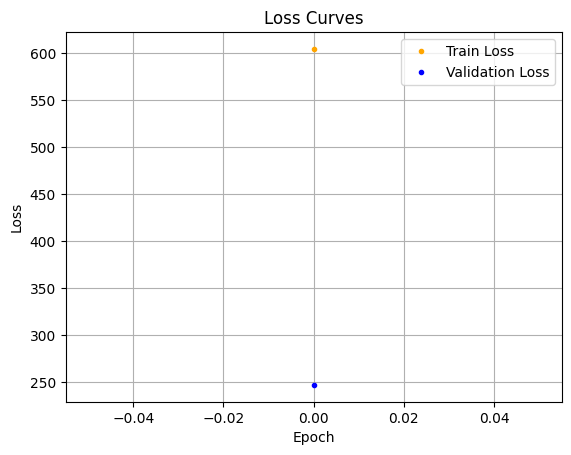


Epoch 1
---------


Train Loss: 243.5652 -|- Validation Loss: 128.7713 -|- Epoch Time: 35.6066 seconds


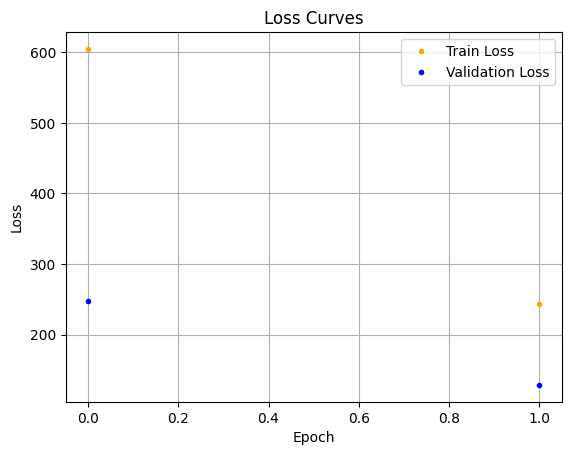


Epoch 2
---------


Train Loss: 155.1457 -|- Validation Loss: 82.2704 -|- Epoch Time: 36.0156 seconds


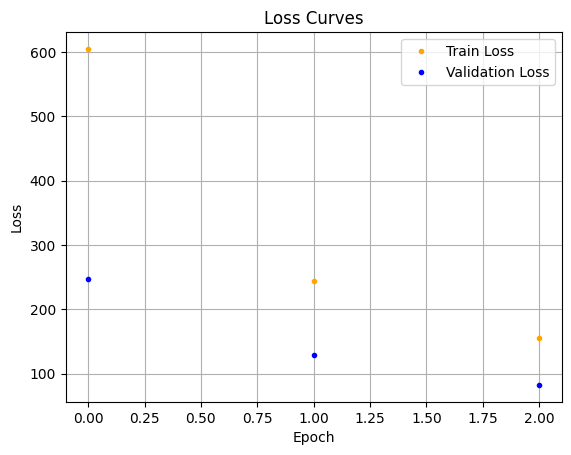


Epoch 3
---------


Train Loss: 114.5957 -|- Validation Loss: 53.0751 -|- Epoch Time: 36.0921 seconds


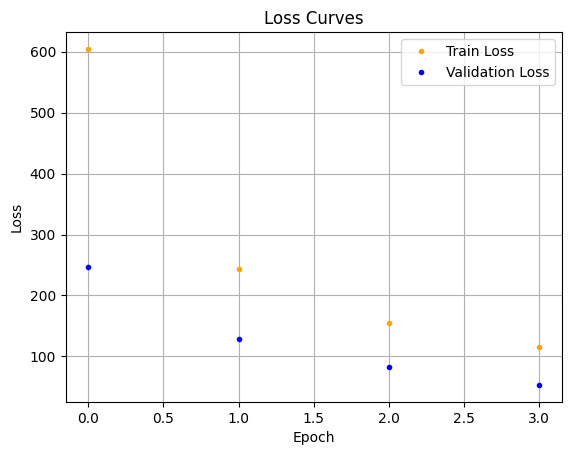


Epoch 4
---------


Train Loss: 91.8432 -|- Validation Loss: 43.0370 -|- Epoch Time: 36.3301 seconds


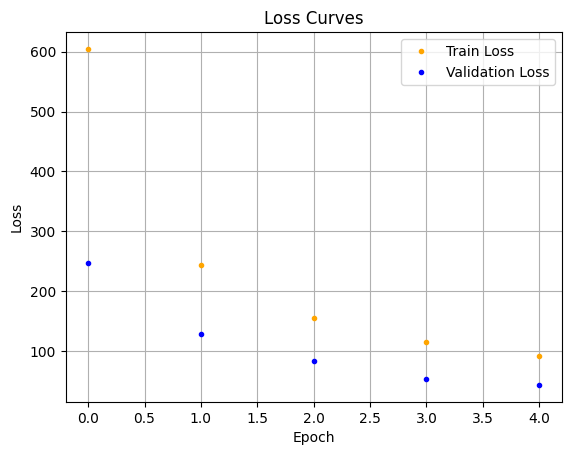


Epoch 5
---------


Train Loss: 81.9748 -|- Validation Loss: 35.4639 -|- Epoch Time: 36.3254 seconds


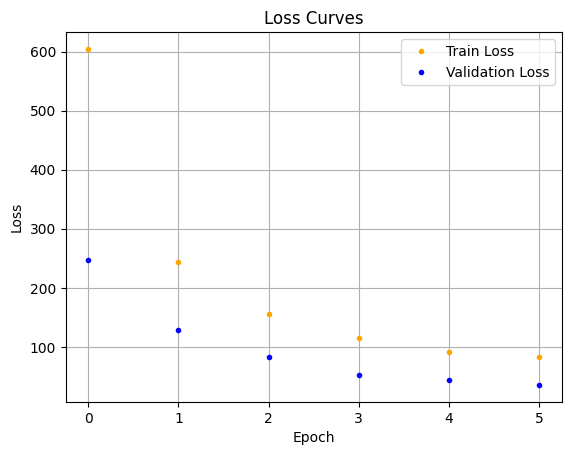


Epoch 6
---------


Train Loss: 75.7466 -|- Validation Loss: 31.0038 -|- Epoch Time: 36.3523 seconds


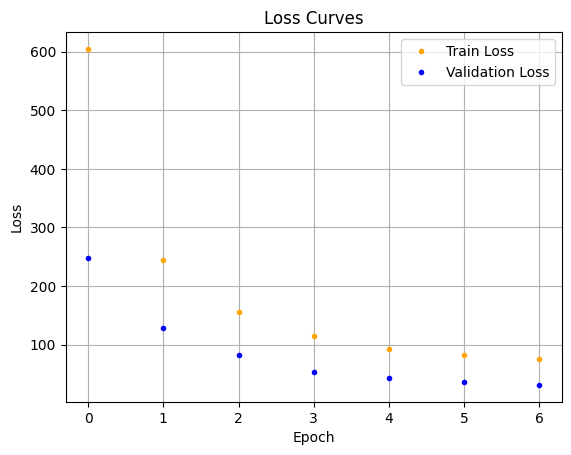


Epoch 7
---------


Train Loss: 71.7514 -|- Validation Loss: 29.6893 -|- Epoch Time: 36.2807 seconds


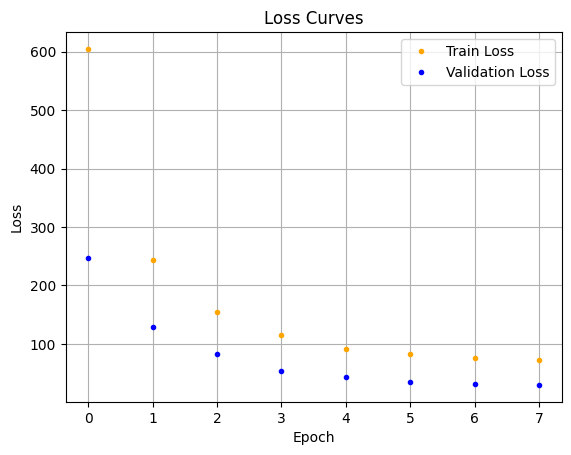


Epoch 8
---------


Train Loss: 68.1844 -|- Validation Loss: 27.4520 -|- Epoch Time: 35.7261 seconds


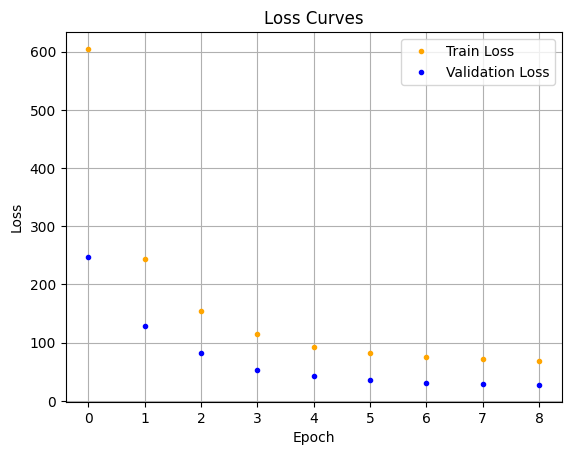


Epoch 9
---------


Train Loss: 66.4265 -|- Validation Loss: 26.2606 -|- Epoch Time: 35.7412 seconds


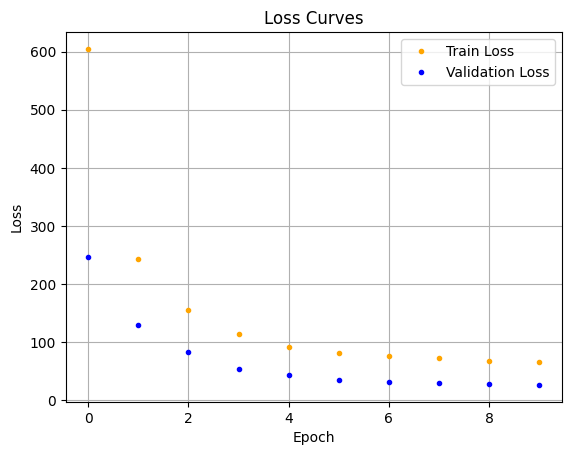


Epoch 10
---------


Train Loss: 64.7918 -|- Validation Loss: 28.2763 -|- Epoch Time: 35.7482 seconds


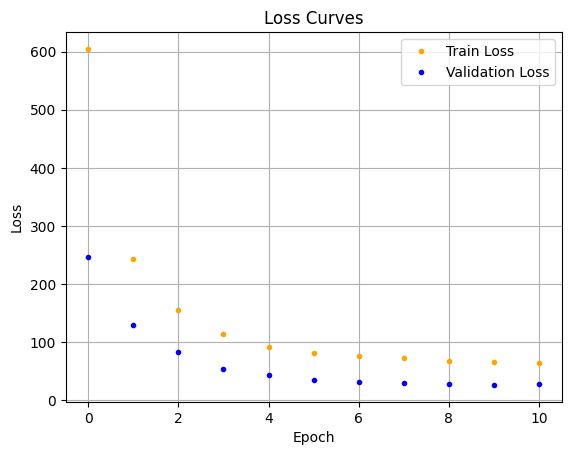


Epoch 11
---------


Train Loss: 63.3755 -|- Validation Loss: 25.7157 -|- Epoch Time: 35.8024 seconds


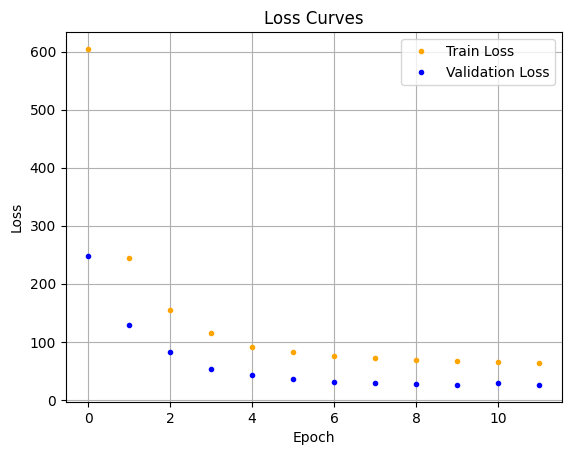


Epoch 12
---------


Train Loss: 62.5960 -|- Validation Loss: 26.5798 -|- Epoch Time: 35.8165 seconds


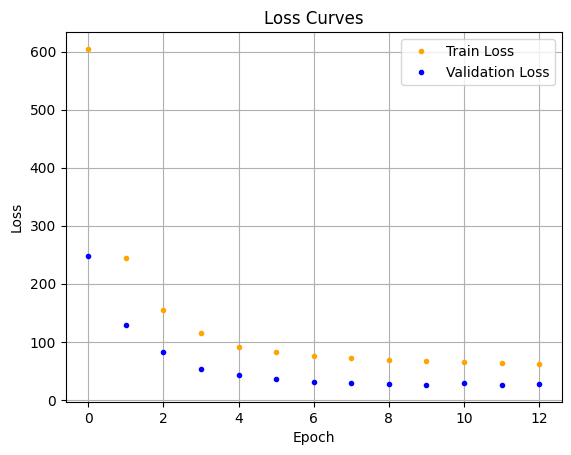


Epoch 13
---------


Train Loss: 61.8785 -|- Validation Loss: 23.6843 -|- Epoch Time: 35.8116 seconds


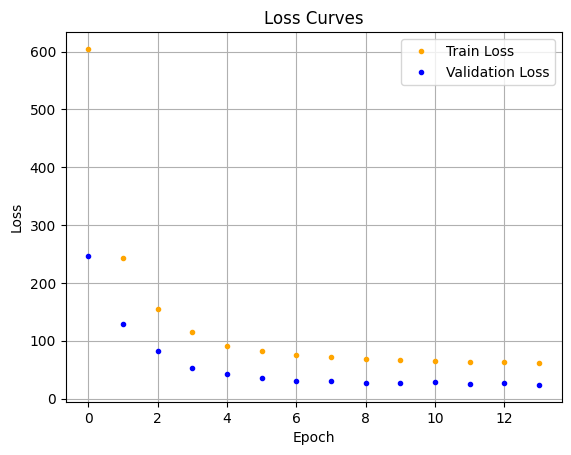


Epoch 14
---------


Train Loss: 60.5226 -|- Validation Loss: 22.7804 -|- Epoch Time: 35.8122 seconds


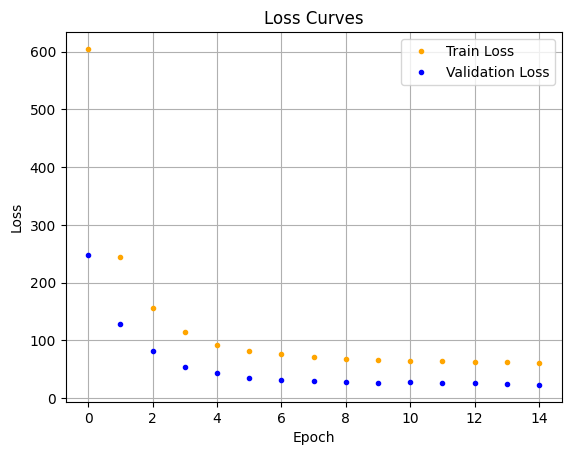


Epoch 15
---------


Train Loss: 58.8667 -|- Validation Loss: 23.2999 -|- Epoch Time: 35.7851 seconds


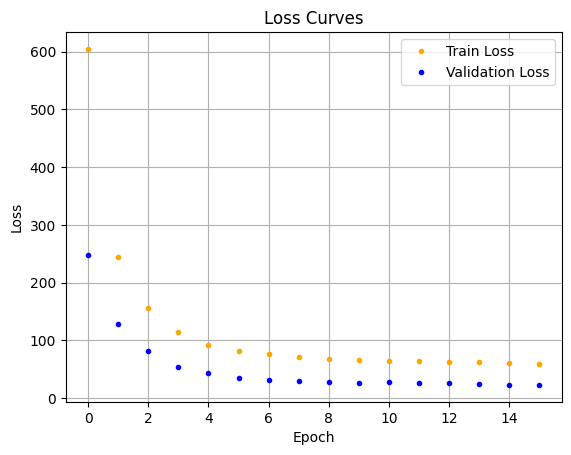


Epoch 16
---------


Train Loss: 57.6759 -|- Validation Loss: 21.6204 -|- Epoch Time: 35.8238 seconds


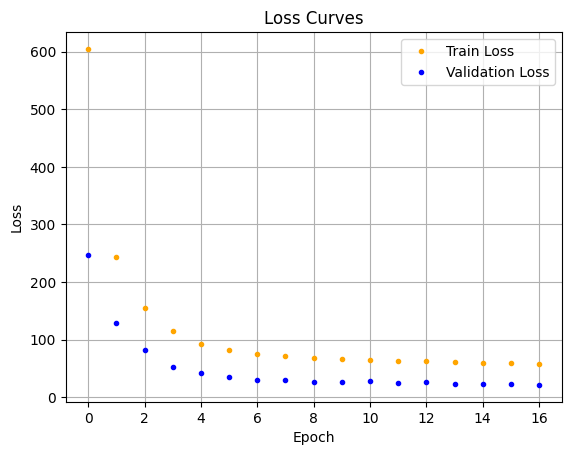


Epoch 17
---------


Train Loss: 57.0490 -|- Validation Loss: 21.3586 -|- Epoch Time: 35.8088 seconds


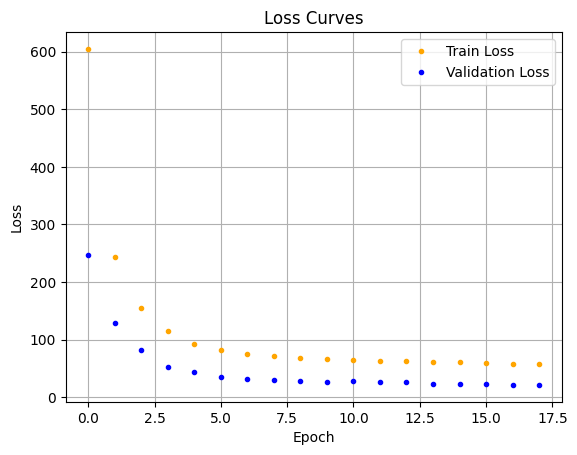


Epoch 18
---------


Train Loss: 55.6813 -|- Validation Loss: 25.0460 -|- Epoch Time: 35.8242 seconds


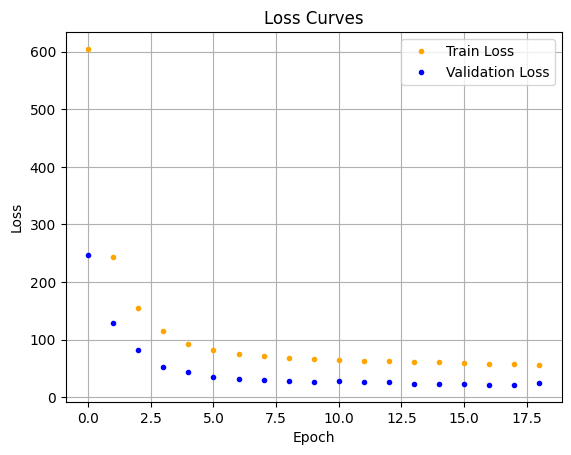


Epoch 19
---------


Train Loss: 55.9014 -|- Validation Loss: 21.7310 -|- Epoch Time: 35.8221 seconds


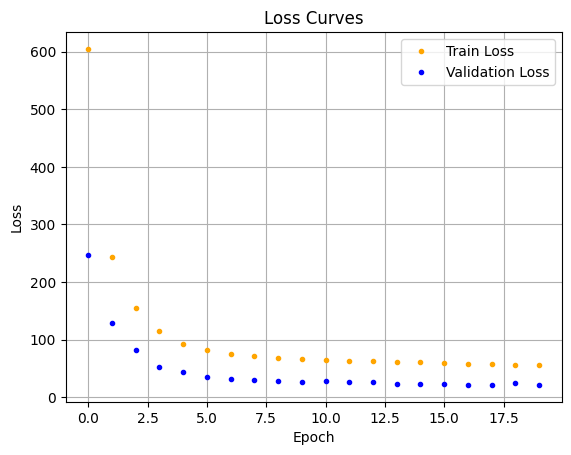


Epoch 20
---------


Train Loss: 54.3476 -|- Validation Loss: 21.3800 -|- Epoch Time: 35.7912 seconds


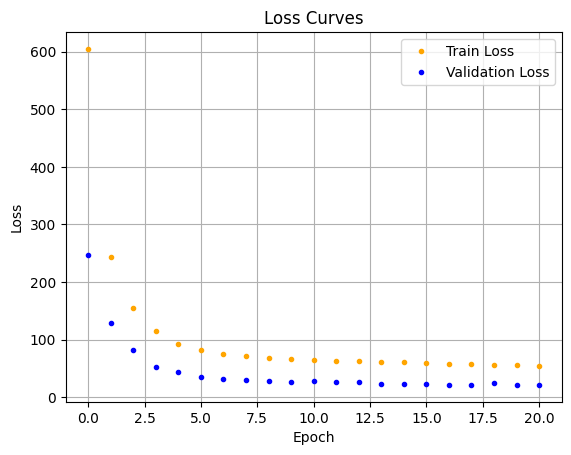


Epoch 21
---------


Train Loss: 53.8211 -|- Validation Loss: 23.3239 -|- Epoch Time: 35.8199 seconds


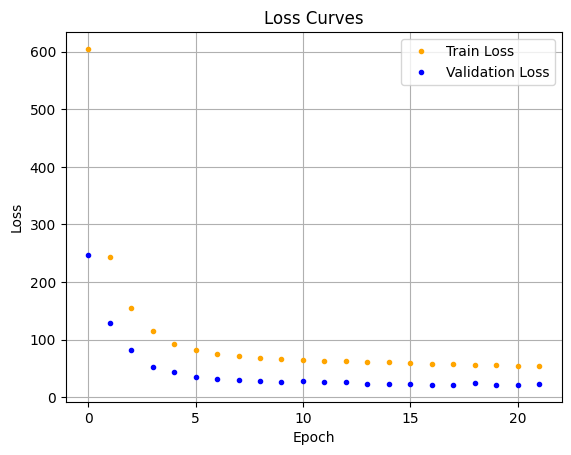


Epoch 22
---------


Train Loss: 53.9006 -|- Validation Loss: 21.6299 -|- Epoch Time: 35.8199 seconds


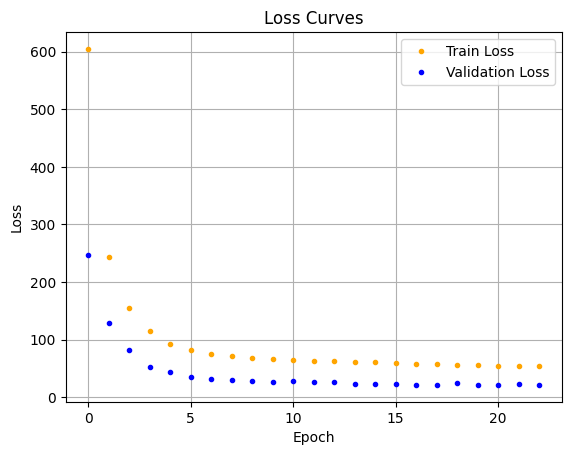


Epoch 23
---------


Train Loss: 53.0306 -|- Validation Loss: 22.1861 -|- Epoch Time: 35.8374 seconds


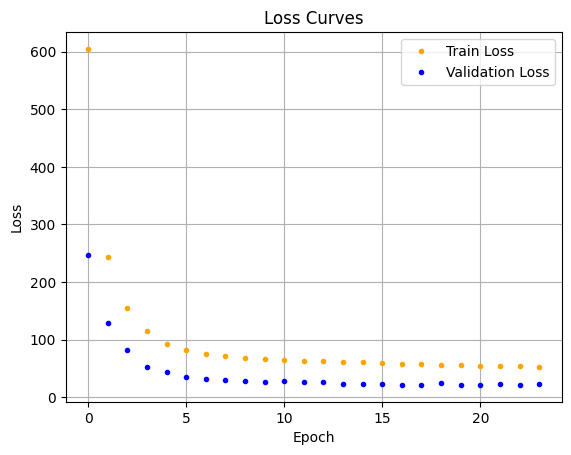


Epoch 24
---------


Train Loss: 52.7046 -|- Validation Loss: 20.2480 -|- Epoch Time: 35.8380 seconds


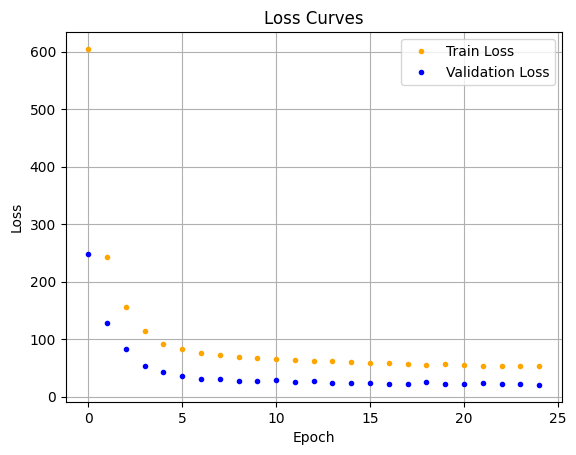


Epoch 25
---------


Train Loss: 51.8593 -|- Validation Loss: 21.9910 -|- Epoch Time: 35.8296 seconds


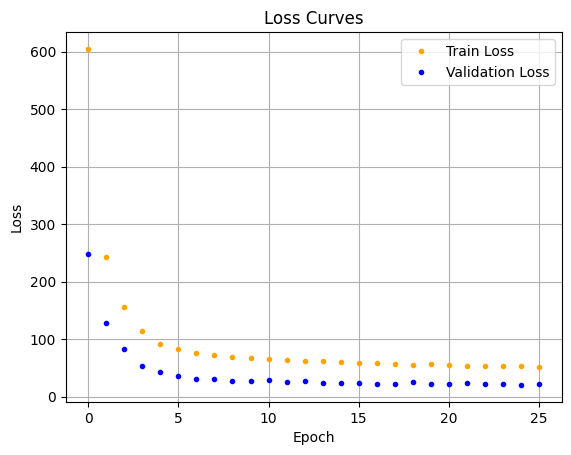


Epoch 26
---------


Train Loss: 51.8675 -|- Validation Loss: 20.5532 -|- Epoch Time: 35.8203 seconds


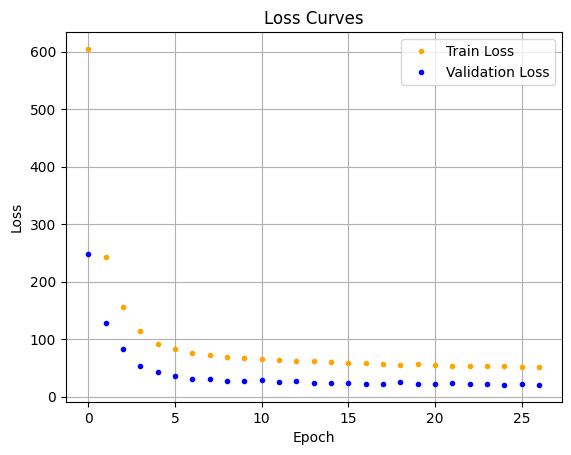


Epoch 27
---------


Train Loss: 51.0067 -|- Validation Loss: 22.7471 -|- Epoch Time: 35.8078 seconds


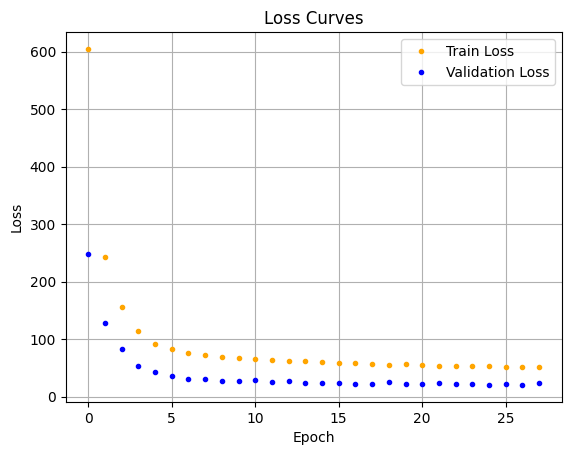


Epoch 28
---------


Train Loss: 51.6057 -|- Validation Loss: 24.6348 -|- Epoch Time: 35.8443 seconds


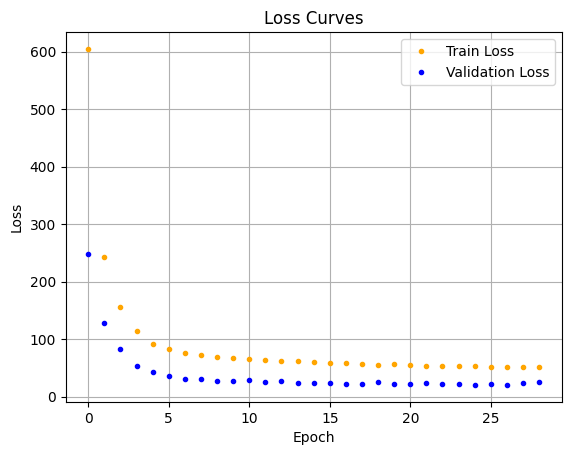


Epoch 29
---------


Train Loss: 49.9464 -|- Validation Loss: 21.8266 -|- Epoch Time: 35.8011 seconds


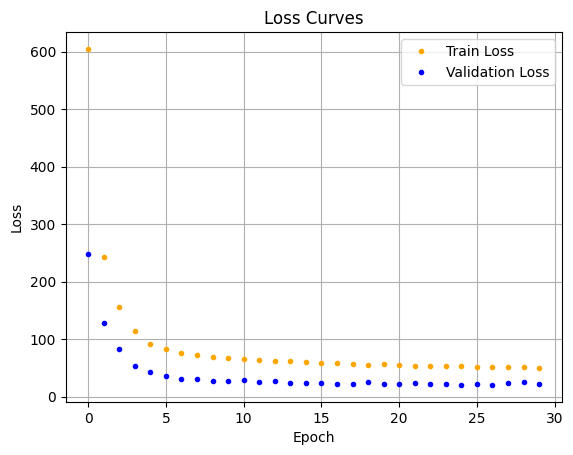


Epoch 30
---------


Train Loss: 49.8727 -|- Validation Loss: 26.0717 -|- Epoch Time: 35.8105 seconds


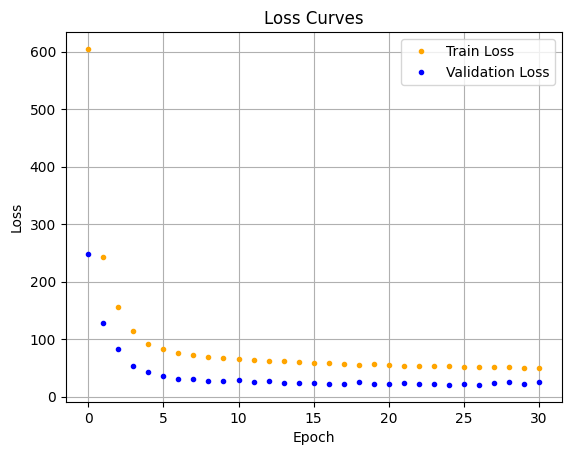


Epoch 31
---------


Train Loss: 49.4742 -|- Validation Loss: 25.8557 -|- Epoch Time: 35.8255 seconds


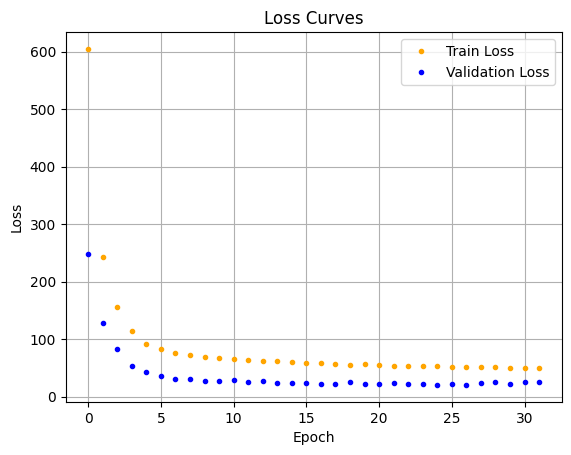


Epoch 32
---------


Train Loss: 48.9376 -|- Validation Loss: 23.6808 -|- Epoch Time: 35.8382 seconds


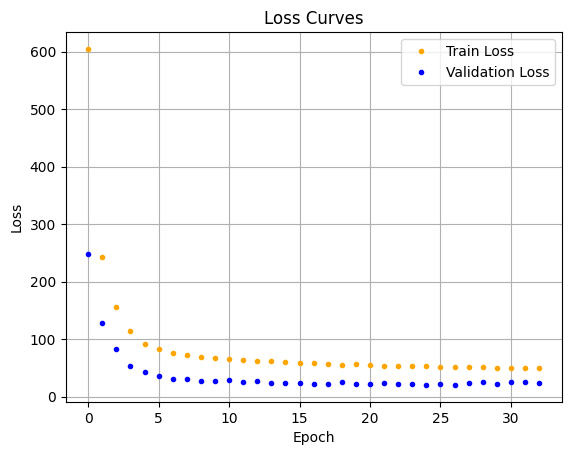


Epoch 33
---------


Train Loss: 48.5863 -|- Validation Loss: 20.6993 -|- Epoch Time: 35.8212 seconds


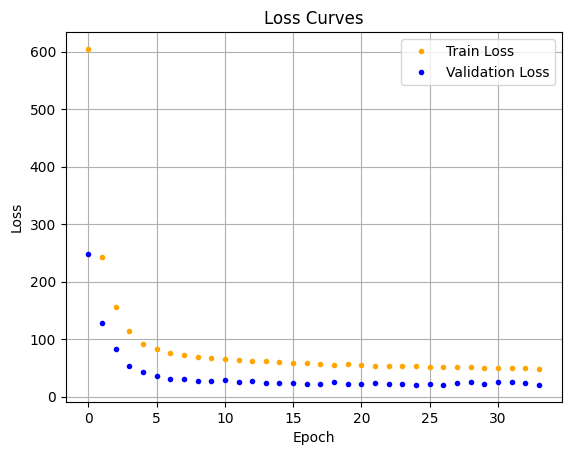


Epoch 34
---------


Train Loss: 47.9097 -|- Validation Loss: 23.5063 -|- Epoch Time: 35.8354 seconds


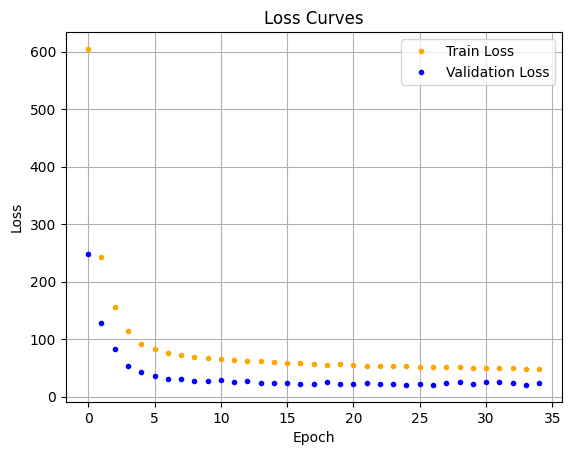


Epoch 35
---------


Train Loss: 47.9950 -|- Validation Loss: 24.3485 -|- Epoch Time: 35.8232 seconds


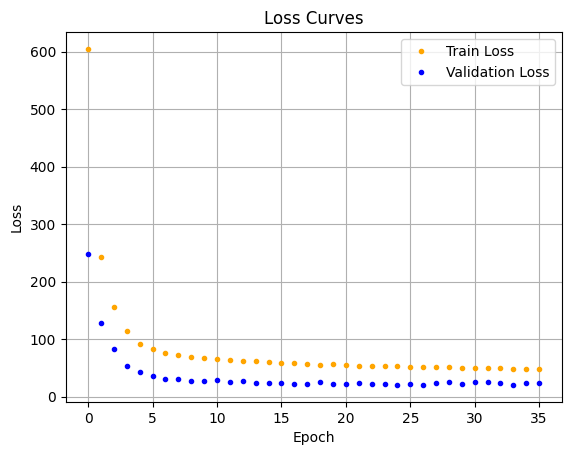


Epoch 36
---------


Train Loss: 47.4208 -|- Validation Loss: 22.7085 -|- Epoch Time: 35.8221 seconds


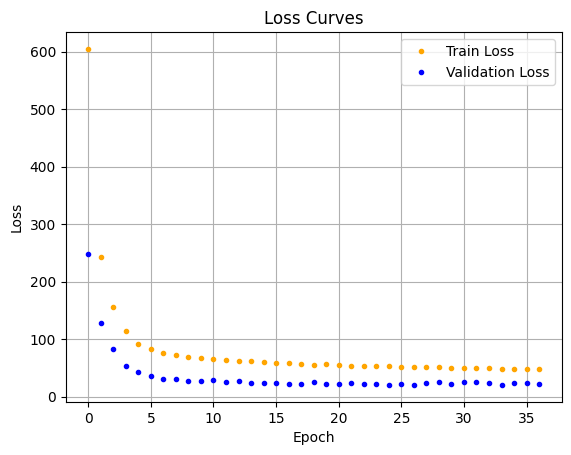


Epoch 37
---------


Train Loss: 47.5677 -|- Validation Loss: 22.5480 -|- Epoch Time: 35.8337 seconds


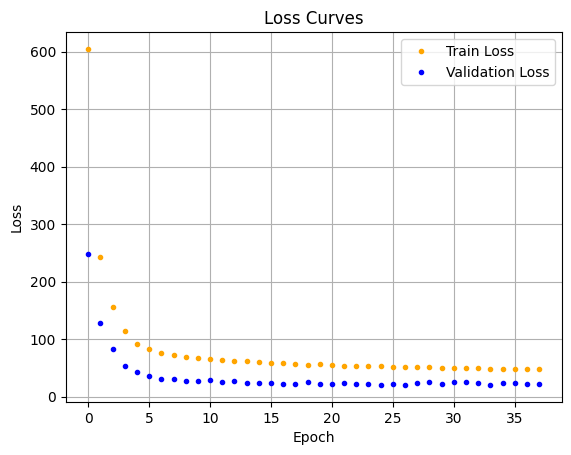


Epoch 38
---------


Train Loss: 47.1853 -|- Validation Loss: 28.9132 -|- Epoch Time: 35.8232 seconds


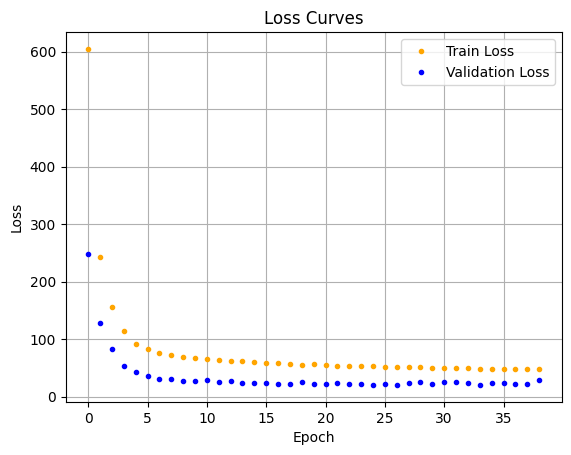


Epoch 39
---------


Train Loss: 46.4766 -|- Validation Loss: 26.1480 -|- Epoch Time: 35.8299 seconds


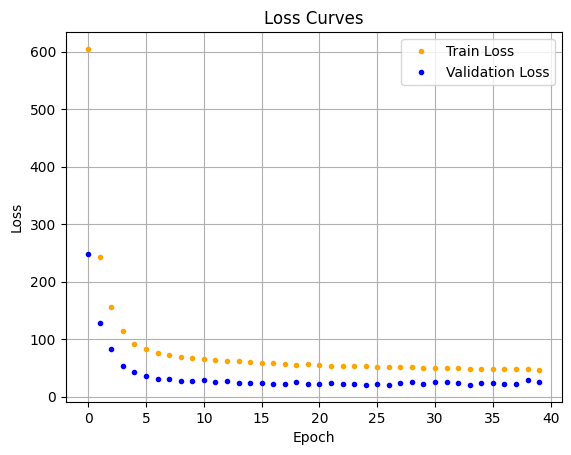


Epoch 40
---------


Train Loss: 46.1670 -|- Validation Loss: 28.1234 -|- Epoch Time: 35.8326 seconds


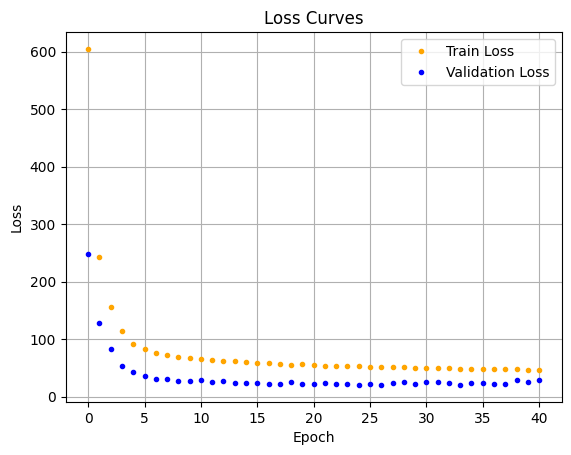


Epoch 41
---------


Train Loss: 45.9384 -|- Validation Loss: 34.0013 -|- Epoch Time: 35.8407 seconds


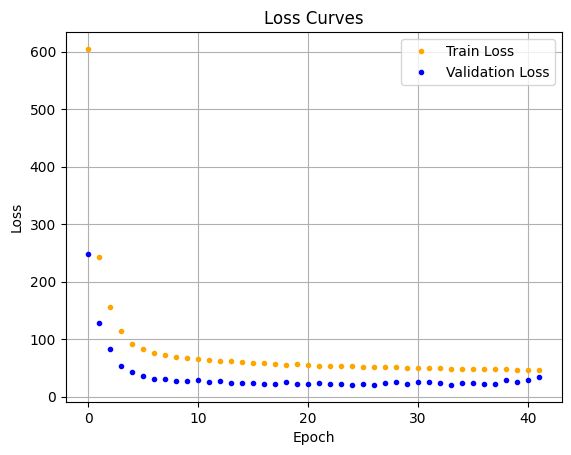


Epoch 42
---------


Train Loss: 46.0525 -|- Validation Loss: 31.1554 -|- Epoch Time: 35.8079 seconds


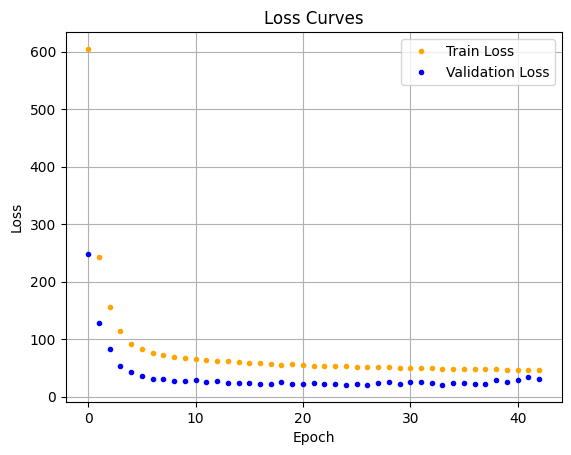


Epoch 43
---------


Train Loss: 45.0259 -|- Validation Loss: 27.3567 -|- Epoch Time: 35.8661 seconds


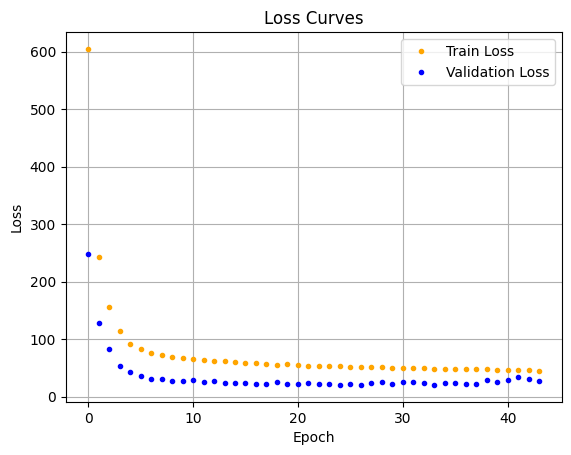


Epoch 44
---------


Train Loss: 45.0247 -|- Validation Loss: 31.7312 -|- Epoch Time: 35.8337 seconds


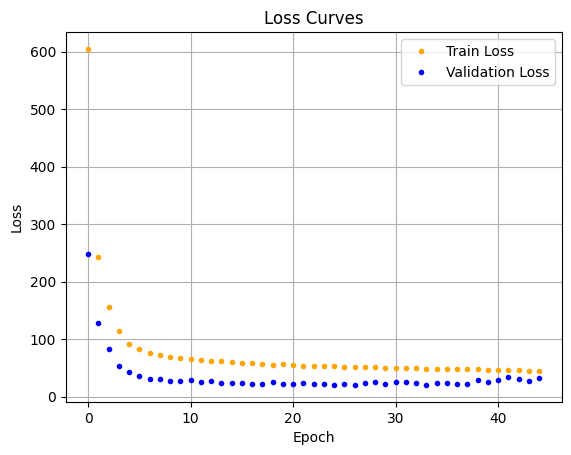


Epoch 45
---------


Train Loss: 45.0197 -|- Validation Loss: 27.3728 -|- Epoch Time: 35.8643 seconds


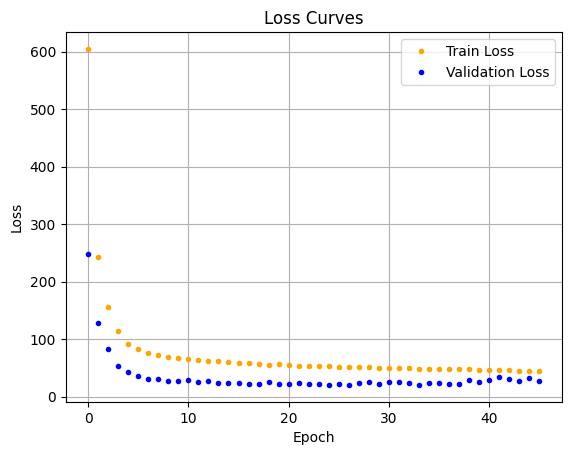


Epoch 46
---------


Train Loss: 44.1225 -|- Validation Loss: 26.4094 -|- Epoch Time: 35.8396 seconds


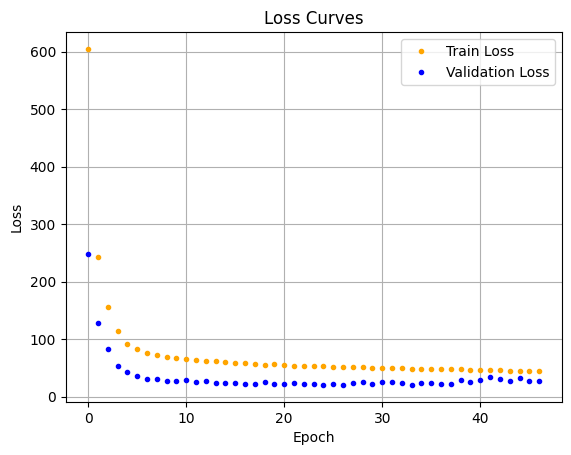


Epoch 47
---------


Train Loss: 44.0778 -|- Validation Loss: 28.7850 -|- Epoch Time: 35.7992 seconds


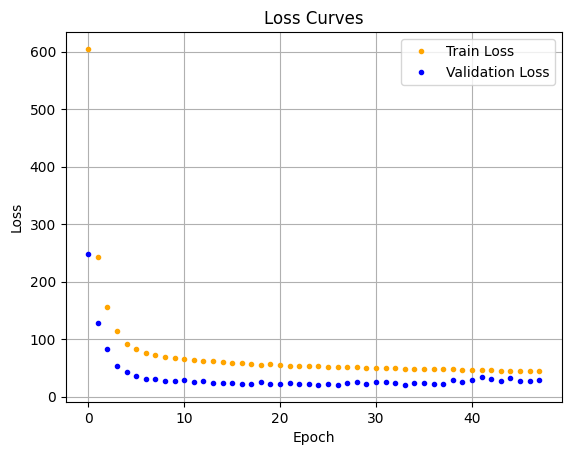


Epoch 48
---------


Train Loss: 43.7095 -|- Validation Loss: 31.0682 -|- Epoch Time: 35.8282 seconds


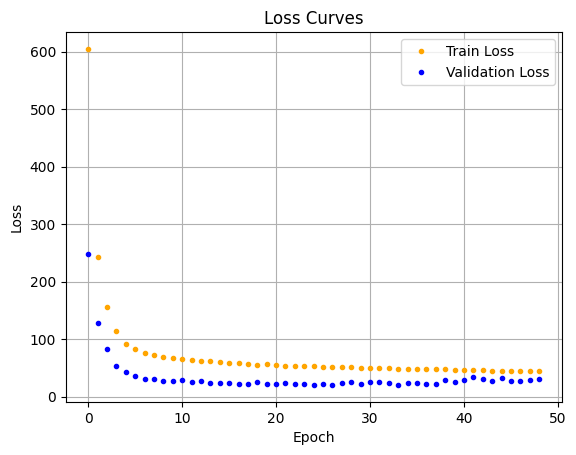


Epoch 49
---------


Train Loss: 43.2911 -|- Validation Loss: 33.5048 -|- Epoch Time: 35.8421 seconds


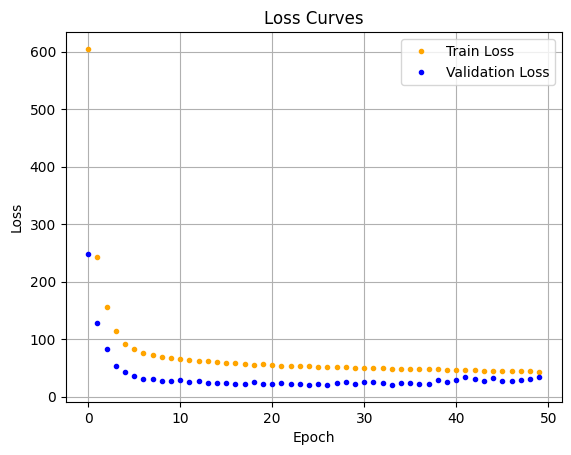


Epoch 50
---------


Train Loss: 43.6397 -|- Validation Loss: 31.5018 -|- Epoch Time: 35.8038 seconds


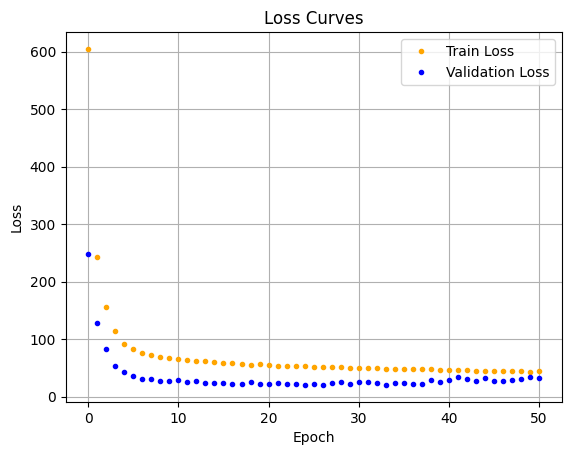


Epoch 51
---------


Train Loss: 43.0795 -|- Validation Loss: 34.1133 -|- Epoch Time: 35.8267 seconds


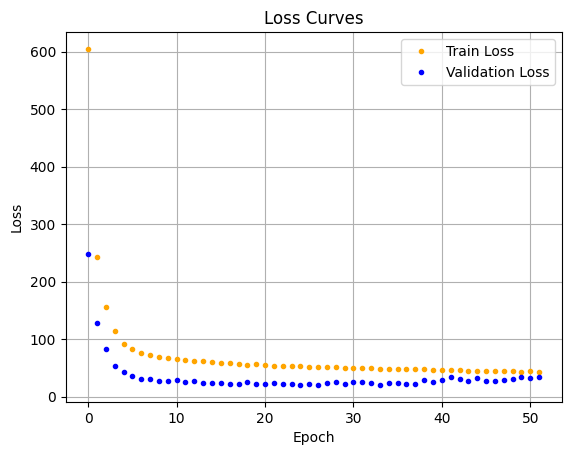


Epoch 52
---------


Train Loss: 42.5878 -|- Validation Loss: 28.4080 -|- Epoch Time: 35.8471 seconds


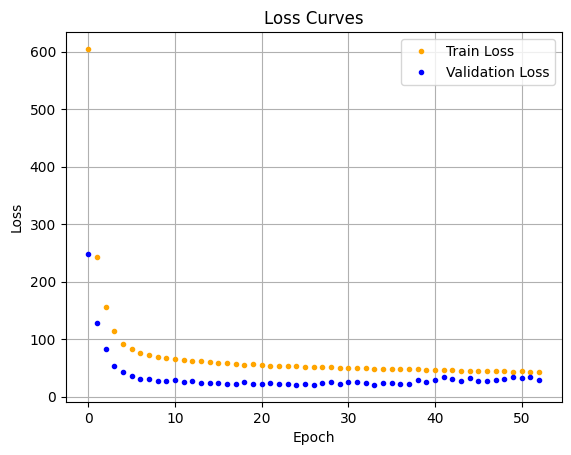


Epoch 53
---------


Train Loss: 42.2968 -|- Validation Loss: 29.0294 -|- Epoch Time: 35.8502 seconds


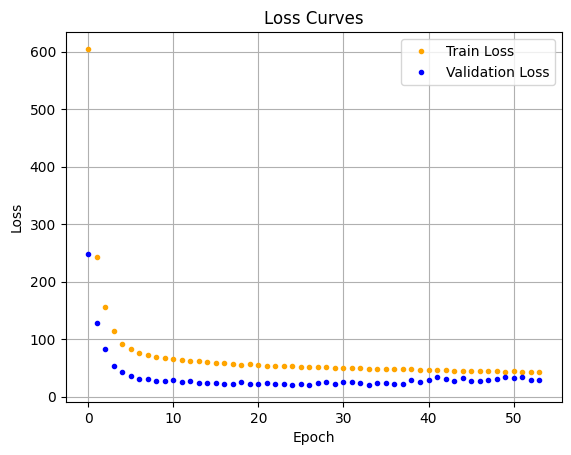


Epoch 54
---------


Train Loss: 42.4040 -|- Validation Loss: 31.3100 -|- Epoch Time: 35.8546 seconds


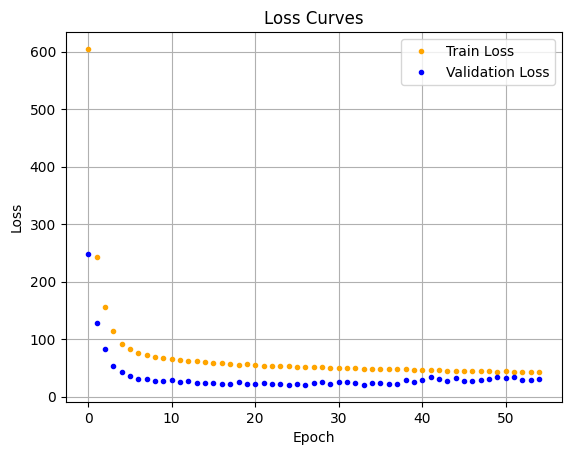


Epoch 55
---------


Train Loss: 41.6650 -|- Validation Loss: 34.8428 -|- Epoch Time: 35.8492 seconds


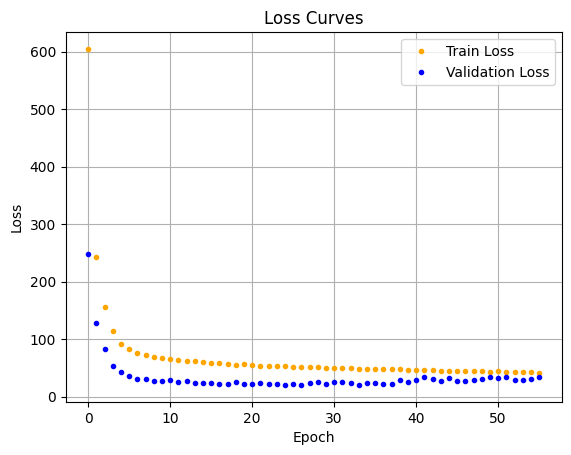


Epoch 56
---------


Train Loss: 41.5213 -|- Validation Loss: 32.9325 -|- Epoch Time: 35.8397 seconds


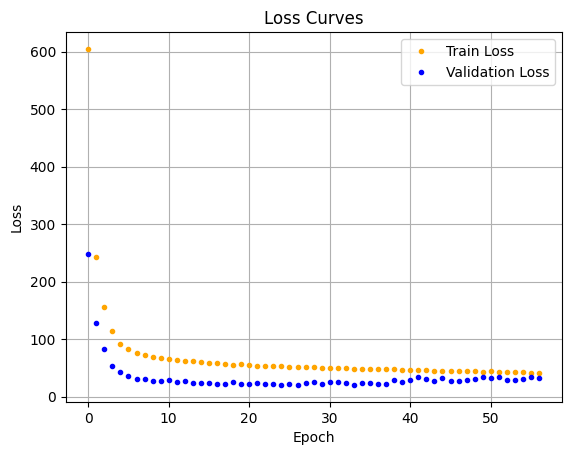


Epoch 57
---------


Train Loss: 40.9846 -|- Validation Loss: 34.7015 -|- Epoch Time: 35.8329 seconds


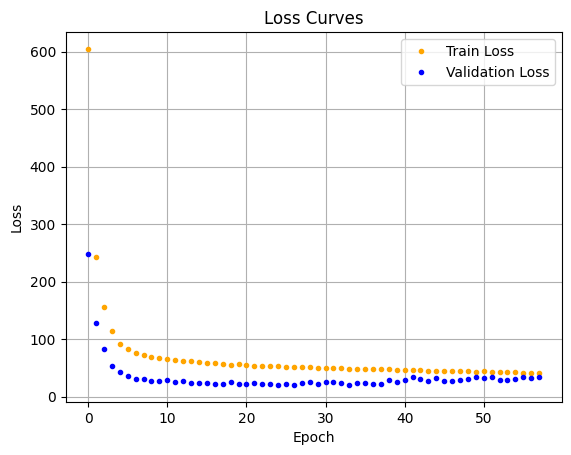


Epoch 58
---------


Train Loss: 40.6003 -|- Validation Loss: 37.7405 -|- Epoch Time: 35.8688 seconds


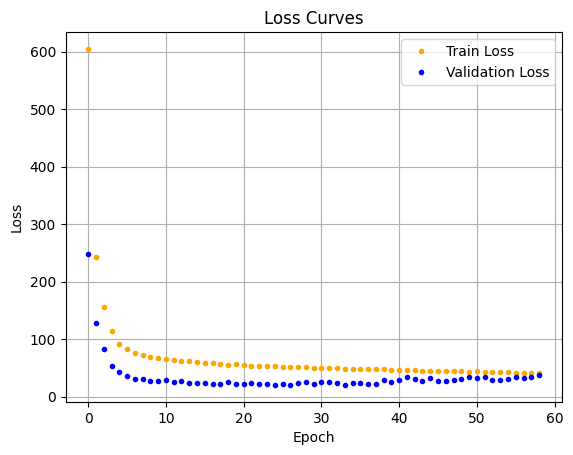


Epoch 59
---------


Train Loss: 40.3944 -|- Validation Loss: 34.4357 -|- Epoch Time: 35.8266 seconds


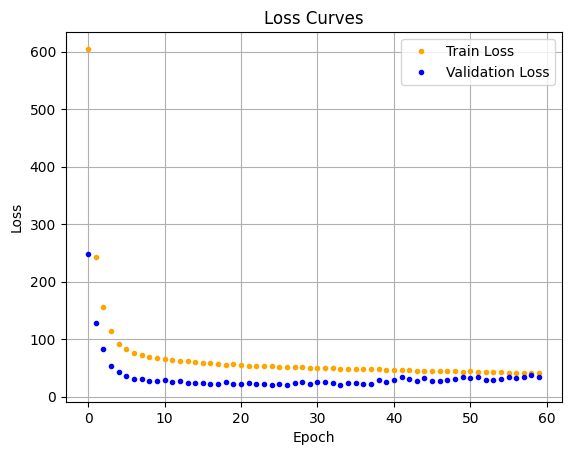


Epoch 60
---------


Train Loss: 40.3309 -|- Validation Loss: 35.5743 -|- Epoch Time: 35.8428 seconds


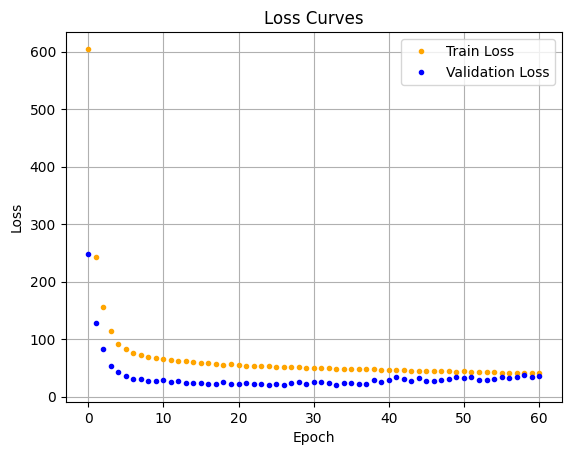


Epoch 61
---------


Train Loss: 39.9136 -|- Validation Loss: 36.6686 -|- Epoch Time: 35.8360 seconds


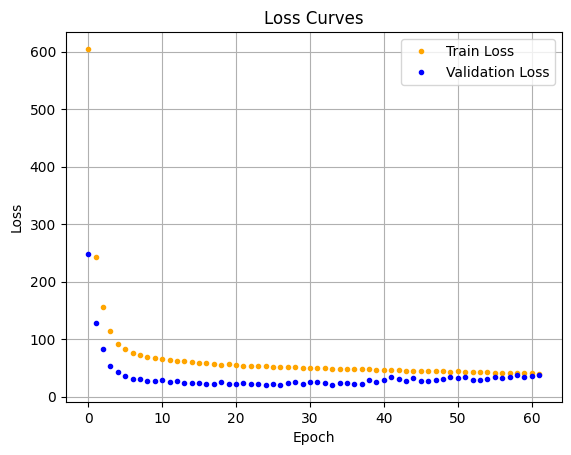


Epoch 62
---------


Train Loss: 39.6334 -|- Validation Loss: 32.2805 -|- Epoch Time: 35.8553 seconds


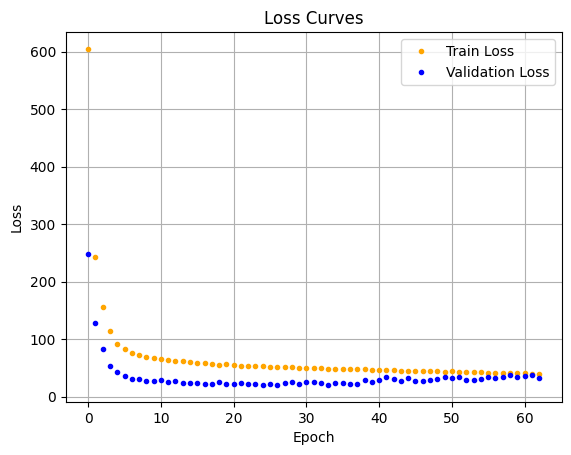


Epoch 63
---------


Train Loss: 39.4301 -|- Validation Loss: 31.3585 -|- Epoch Time: 35.8567 seconds


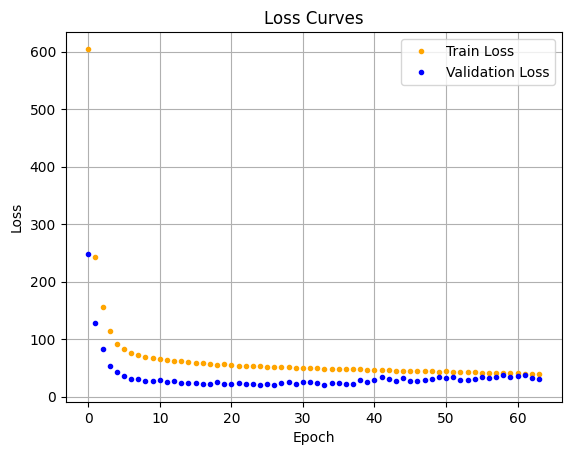


Epoch 64
---------


Train Loss: 38.7530 -|- Validation Loss: 33.1892 -|- Epoch Time: 35.8280 seconds


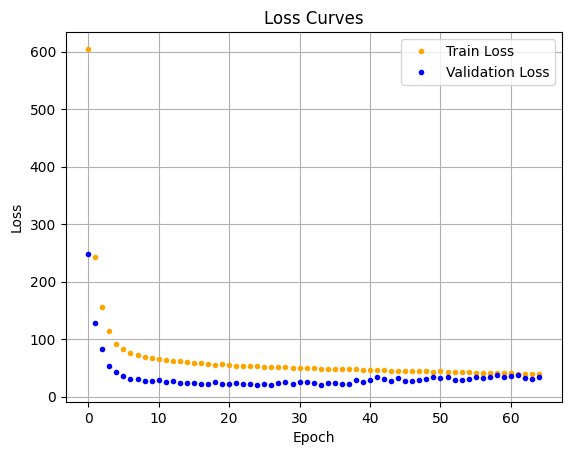


Epoch 65
---------


Train Loss: 38.6456 -|- Validation Loss: 35.7513 -|- Epoch Time: 35.8250 seconds


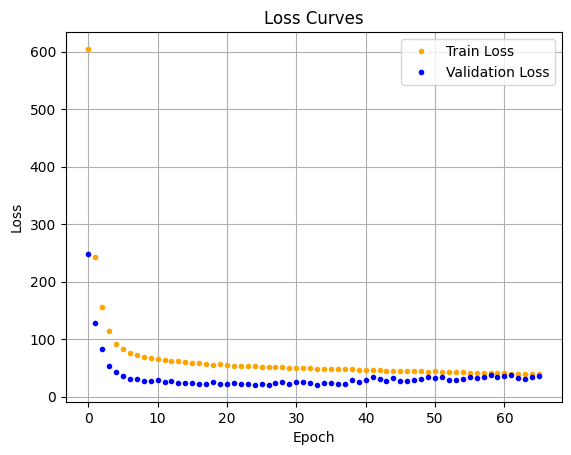


Epoch 66
---------


Train Loss: 38.5653 -|- Validation Loss: 35.3208 -|- Epoch Time: 35.8476 seconds


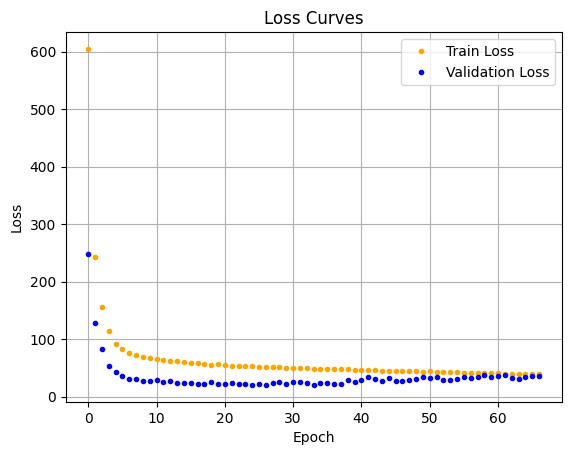


Epoch 67
---------


Train Loss: 38.6756 -|- Validation Loss: 35.9643 -|- Epoch Time: 35.8416 seconds


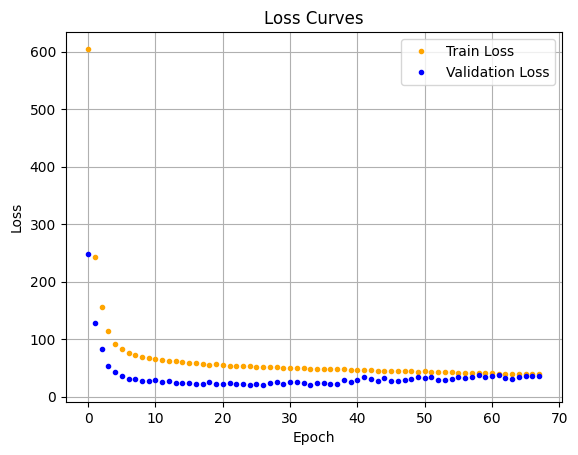


Epoch 68
---------


Train Loss: 37.9521 -|- Validation Loss: 34.8991 -|- Epoch Time: 35.8230 seconds


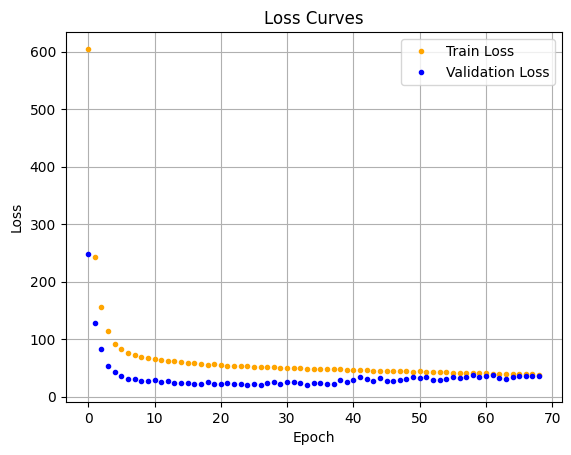


Epoch 69
---------


Train Loss: 37.7263 -|- Validation Loss: 36.3250 -|- Epoch Time: 35.8369 seconds


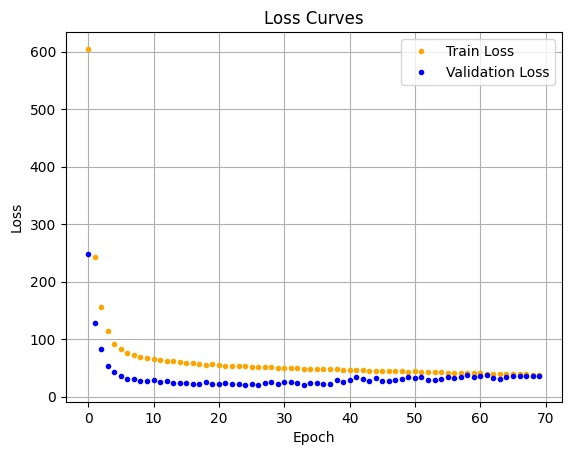


Epoch 70
---------


Train Loss: 37.6566 -|- Validation Loss: 36.6001 -|- Epoch Time: 35.8250 seconds


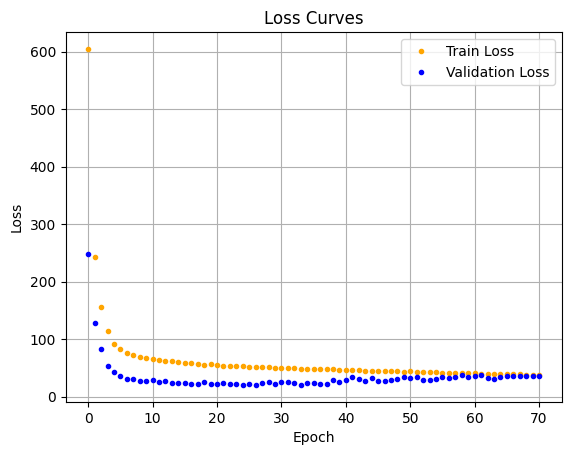


Epoch 71
---------


Train Loss: 37.3891 -|- Validation Loss: 40.9601 -|- Epoch Time: 35.8381 seconds


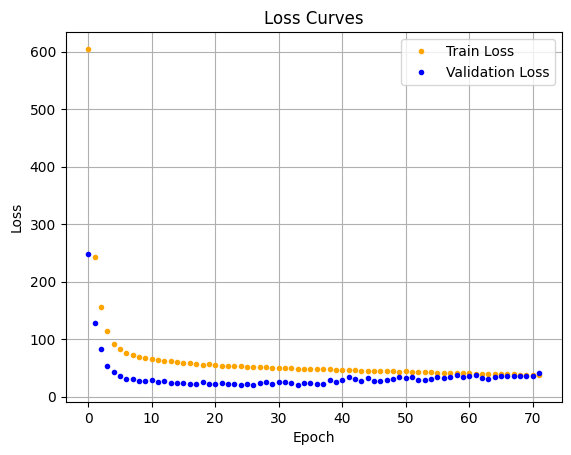


Epoch 72
---------


Train Loss: 36.7231 -|- Validation Loss: 31.3325 -|- Epoch Time: 35.8418 seconds


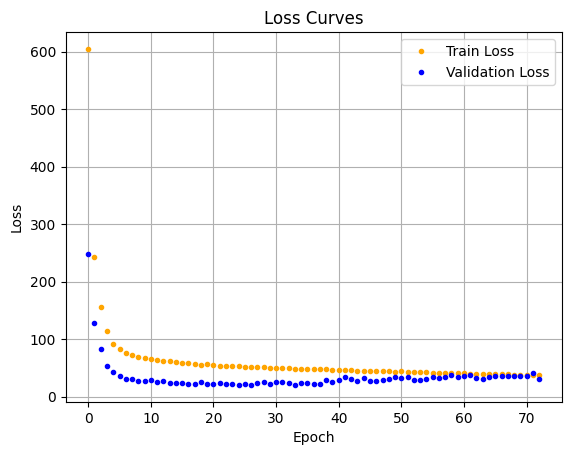


Epoch 73
---------


Train Loss: 36.4345 -|- Validation Loss: 32.2975 -|- Epoch Time: 35.8361 seconds


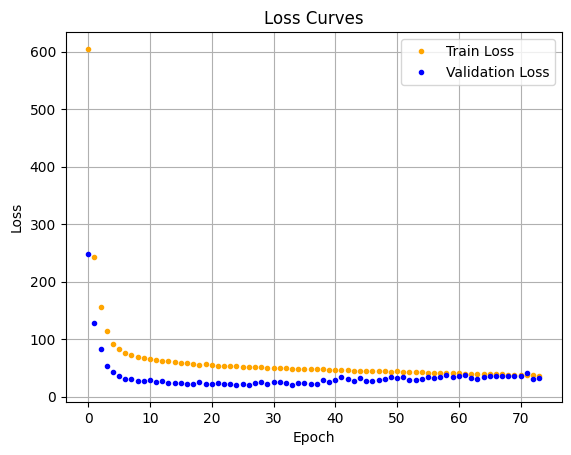


Epoch 74
---------


Train Loss: 36.3706 -|- Validation Loss: 37.6717 -|- Epoch Time: 35.8835 seconds


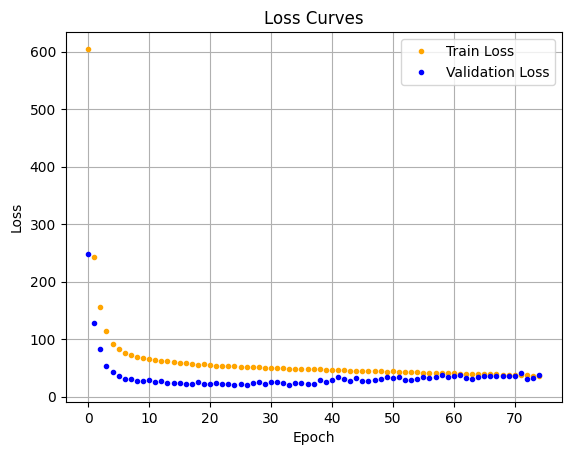


Epoch 75
---------


Train Loss: 35.8135 -|- Validation Loss: 39.3325 -|- Epoch Time: 36.2848 seconds


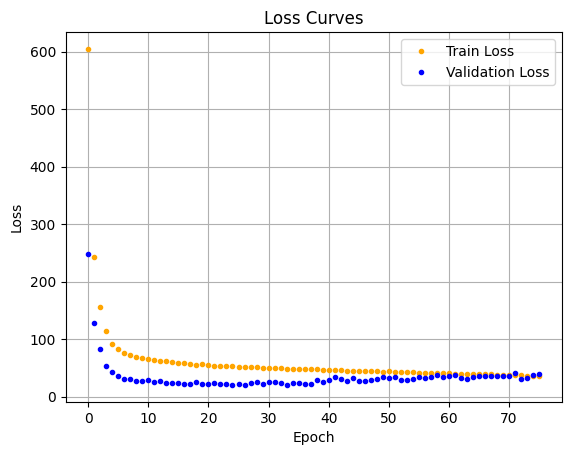


Epoch 76
---------


Train Loss: 36.2124 -|- Validation Loss: 37.0346 -|- Epoch Time: 36.2721 seconds


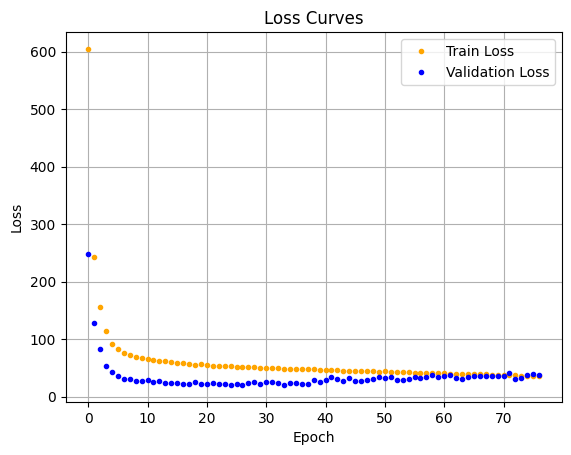


Epoch 77
---------


Train Loss: 35.9723 -|- Validation Loss: 32.9007 -|- Epoch Time: 36.2025 seconds


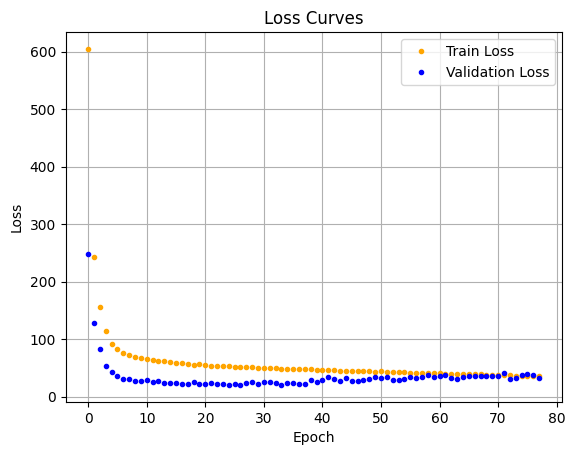


Epoch 78
---------


Train Loss: 35.3233 -|- Validation Loss: 37.9552 -|- Epoch Time: 36.2438 seconds


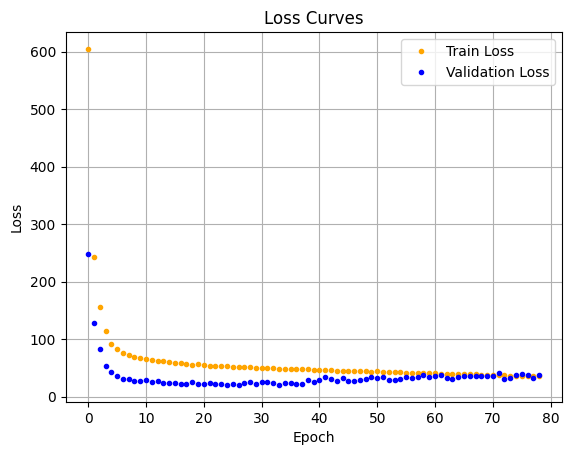


Epoch 79
---------


Train Loss: 35.5212 -|- Validation Loss: 39.0074 -|- Epoch Time: 36.2194 seconds


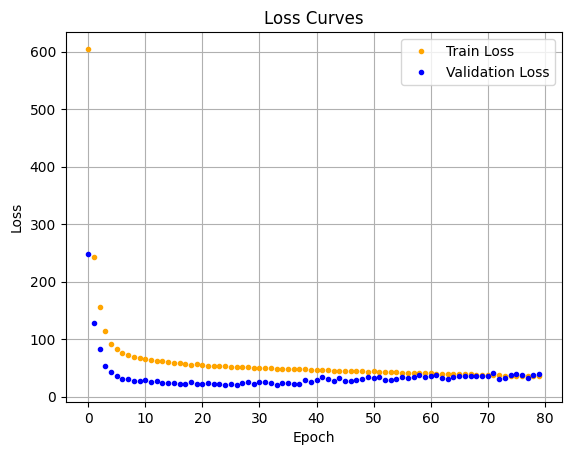


Epoch 80
---------


Train Loss: 35.2960 -|- Validation Loss: 36.1096 -|- Epoch Time: 36.2290 seconds


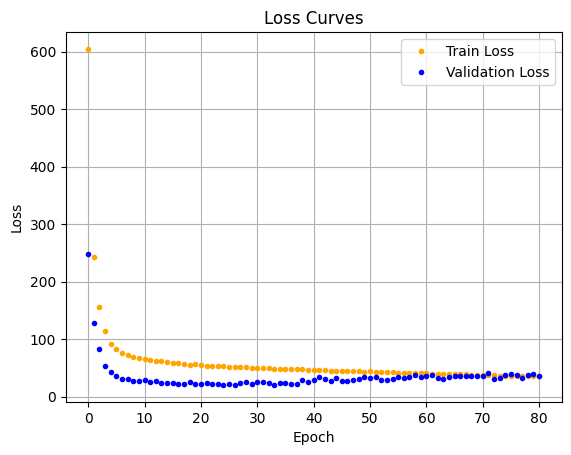


Epoch 81
---------


Train Loss: 34.9808 -|- Validation Loss: 31.3581 -|- Epoch Time: 36.2355 seconds


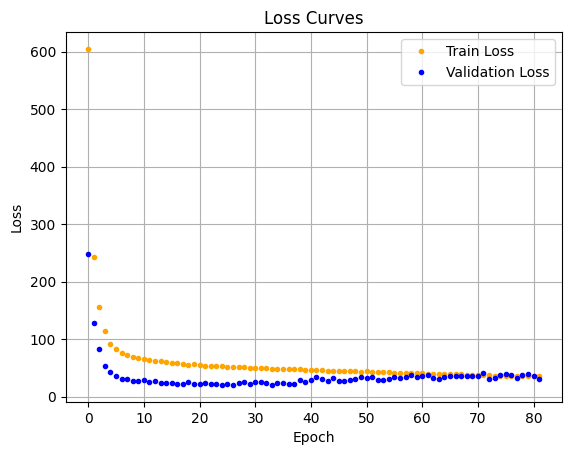


Epoch 82
---------


Train Loss: 34.8138 -|- Validation Loss: 38.2108 -|- Epoch Time: 36.2216 seconds


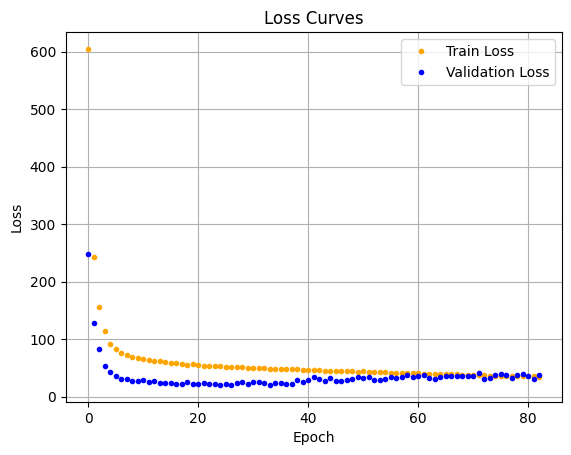


Epoch 83
---------


Train Loss: 34.3149 -|- Validation Loss: 39.0082 -|- Epoch Time: 36.2327 seconds


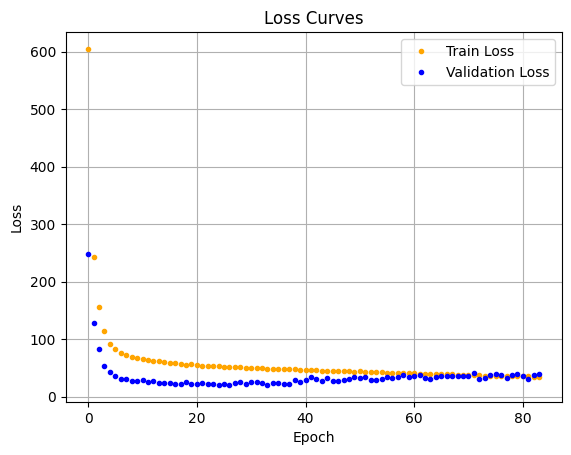


Epoch 84
---------


Train Loss: 34.0970 -|- Validation Loss: 37.0639 -|- Epoch Time: 36.2832 seconds


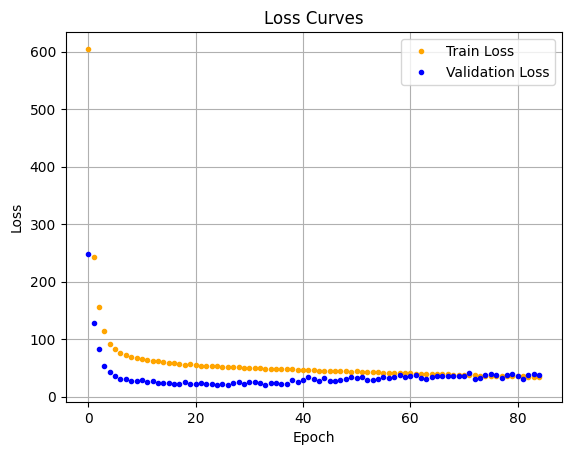


Epoch 85
---------


Train Loss: 34.0664 -|- Validation Loss: 37.4684 -|- Epoch Time: 36.2414 seconds


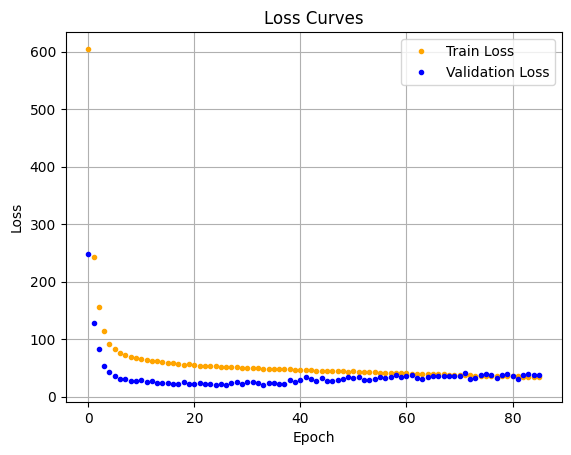


Epoch 86
---------


Train Loss: 34.0548 -|- Validation Loss: 39.0064 -|- Epoch Time: 36.2016 seconds


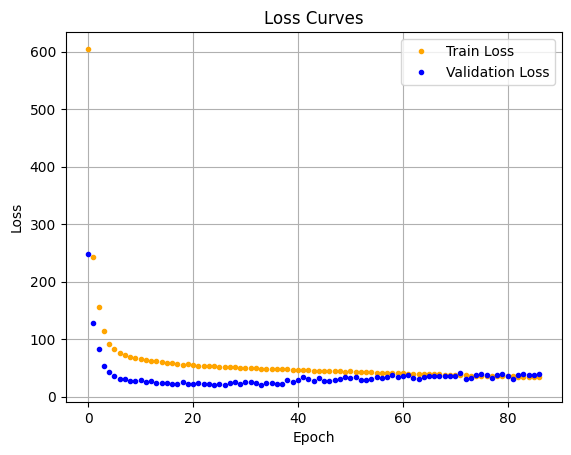


Epoch 87
---------


Train Loss: 33.8352 -|- Validation Loss: 34.6074 -|- Epoch Time: 35.8253 seconds


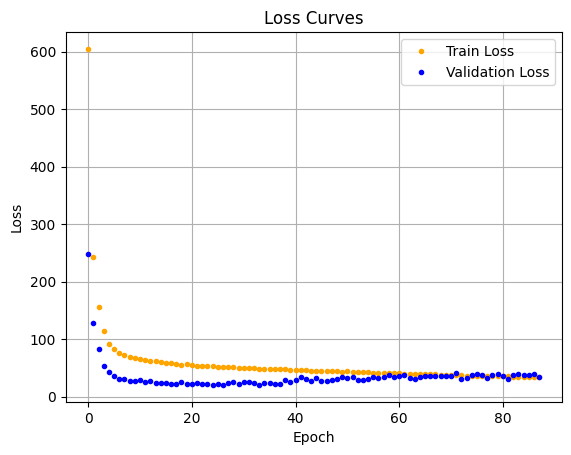


Epoch 88
---------


Train Loss: 33.6825 -|- Validation Loss: 34.4303 -|- Epoch Time: 35.8400 seconds


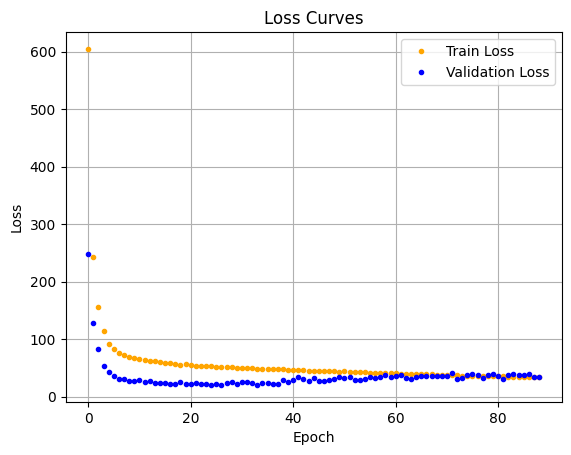


Epoch 89
---------


Train Loss: 33.4310 -|- Validation Loss: 36.5071 -|- Epoch Time: 35.8134 seconds


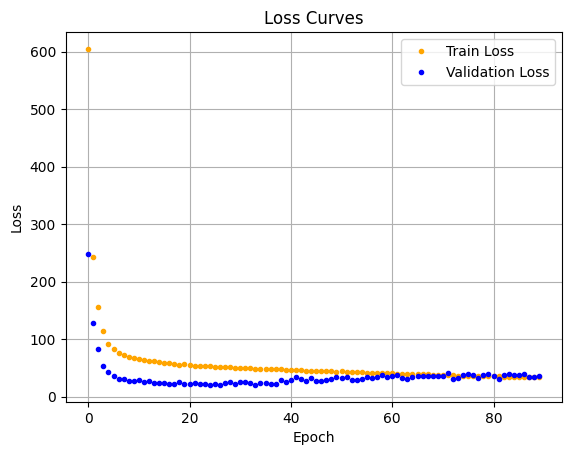


Epoch 90
---------


Train Loss: 32.8956 -|- Validation Loss: 40.6130 -|- Epoch Time: 35.8281 seconds


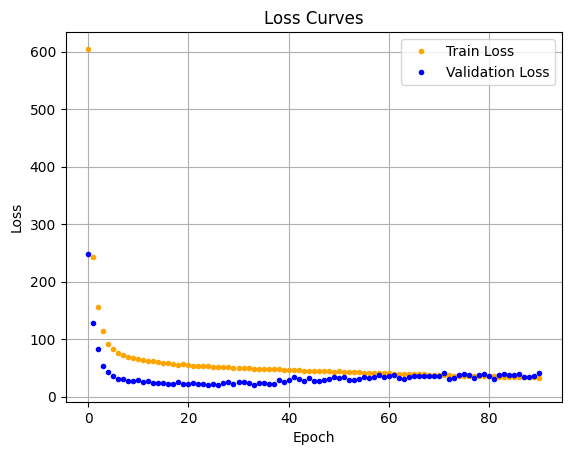


Epoch 91
---------


Train Loss: 33.1161 -|- Validation Loss: 46.5190 -|- Epoch Time: 35.8323 seconds


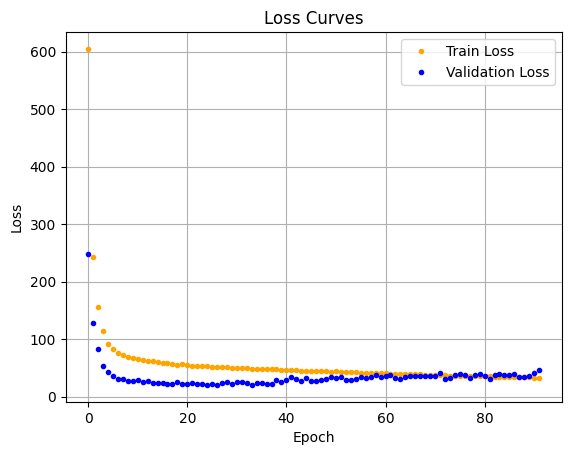


Epoch 92
---------


Train Loss: 32.7815 -|- Validation Loss: 42.0658 -|- Epoch Time: 35.8214 seconds


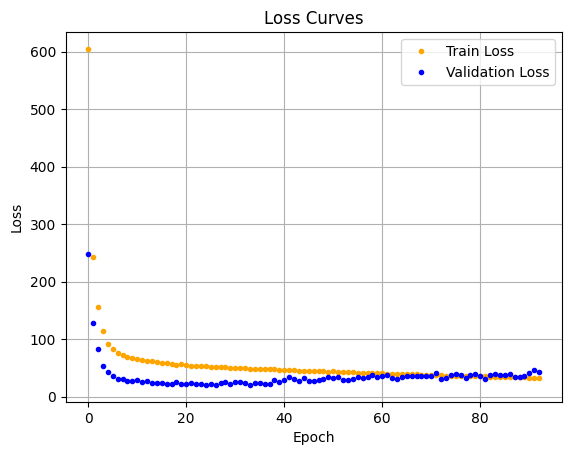


Epoch 93
---------


Train Loss: 32.6622 -|- Validation Loss: 40.9621 -|- Epoch Time: 35.8229 seconds


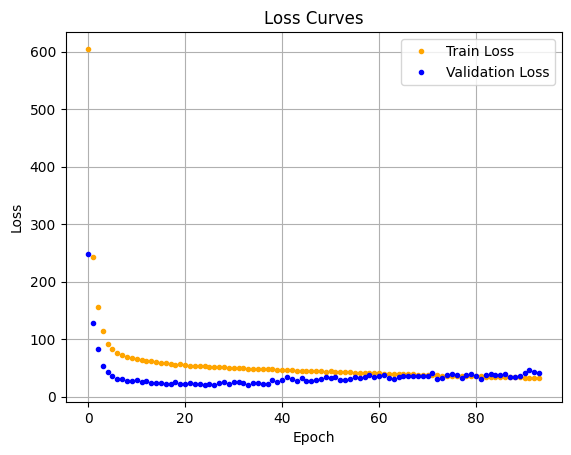


Epoch 94
---------


Train Loss: 32.2748 -|- Validation Loss: 39.4132 -|- Epoch Time: 35.8442 seconds


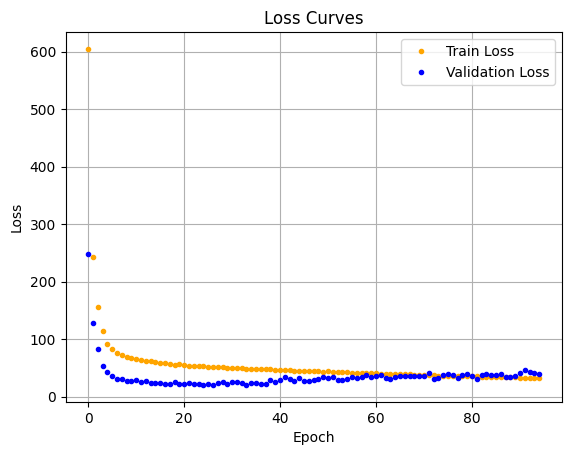


Epoch 95
---------


Train Loss: 32.1006 -|- Validation Loss: 38.6153 -|- Epoch Time: 35.8180 seconds


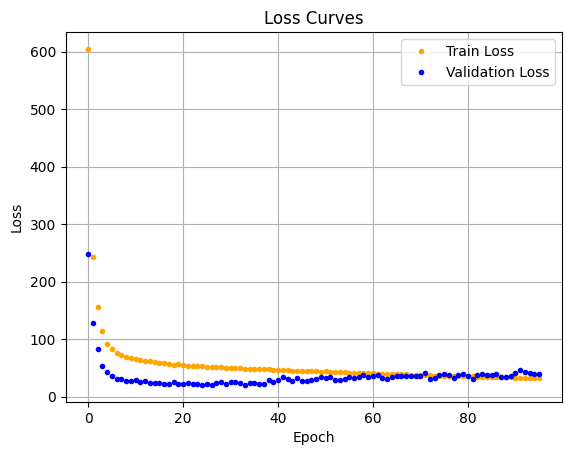


Epoch 96
---------


Train Loss: 32.1500 -|- Validation Loss: 46.8135 -|- Epoch Time: 35.9448 seconds


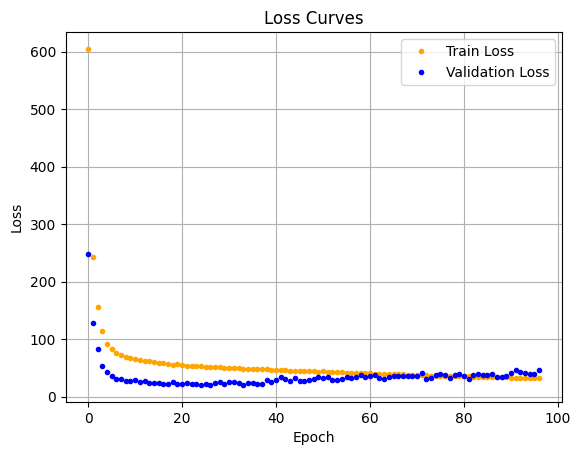


Epoch 97
---------


Train Loss: 31.7180 -|- Validation Loss: 37.7301 -|- Epoch Time: 35.8247 seconds


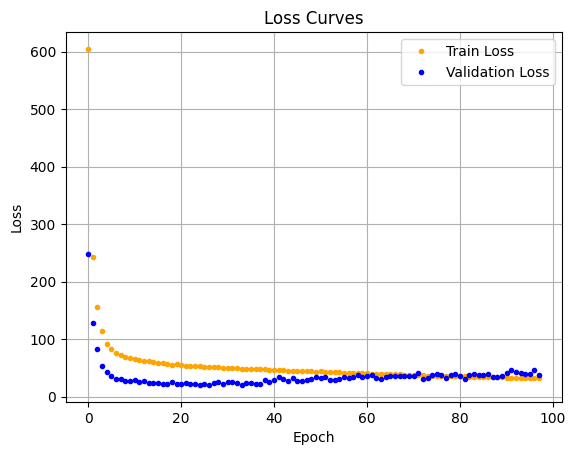


Epoch 98
---------


Train Loss: 31.6408 -|- Validation Loss: 36.1223 -|- Epoch Time: 35.8106 seconds


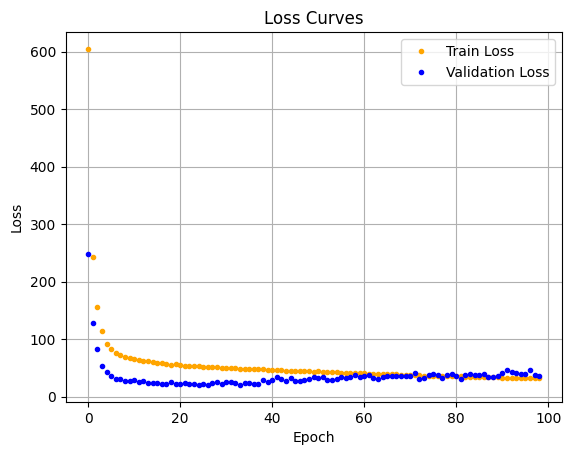


Epoch 99
---------


Train Loss: 31.4887 -|- Validation Loss: 44.3192 -|- Epoch Time: 35.7929 seconds


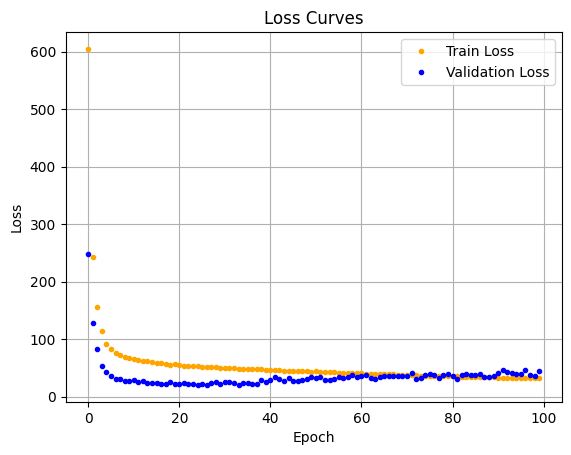

In [13]:
import numpy as np
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

model = model.to('cuda')


train_loss_list = np.array([])
val_loss_list = np.array([])

for ix_epoch in range(100):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, model, loss_function, optimizer, device='cuda')
    validation_loss = validate_model(val_loader, model, loss_function, device='cuda')
    end = time.time()
    epoch_time = end - start
    train_loss_list = np.append(train_loss_list, train_loss)
    val_loss_list = np.append(val_loss_list, validation_loss)
    print(f'Train Loss: {train_loss:0.4f} -|- Validation Loss: {validation_loss:0.4f} -|- Epoch Time: {epoch_time:0.4f} seconds')
    plt.plot(range(len(train_loss_list)),train_loss_list, '.', c='orange', label='Train Loss')
    plt.plot(range(len(train_loss_list)),val_loss_list, '.', c='blue', label='Validation Loss')
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    #plt.savefig(f'Animations/Training_2Stack_{ix_epoch}.png')
    plt.show()
    print()

In [14]:
# Save the entire model (not recommended for production)
torch.save(model, 'Models/Model_2.pth')

R² Score: 0.8701


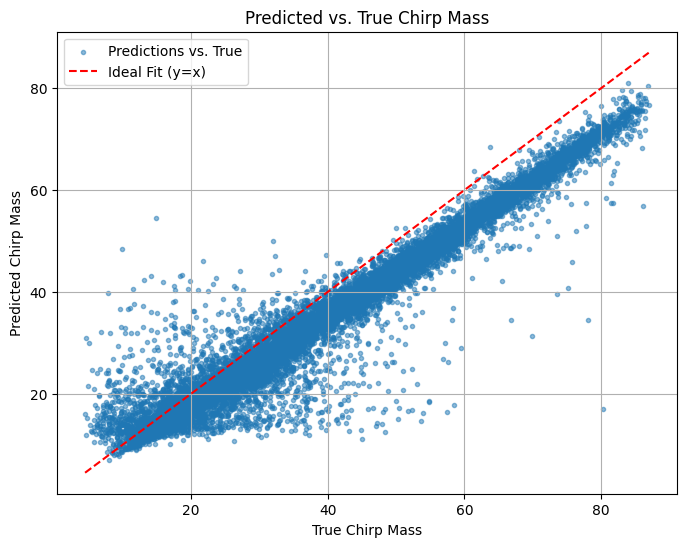

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Set model to evaluation mode
model.eval()

# Store results
predictions = []
true_labels = []

# Disable gradients for evaluation
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to('cuda'), y_test.to('cuda')

        # Get predictions
        outputs = model(X_test)

        # Store predictions and true labels
        predictions.append(outputs.cpu().numpy())
        true_labels.append(y_test.cpu().numpy())

# Convert lists to numpy arrays
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Calculate and plot the R^2
r2 = r2_score(true_labels, predictions)
print(f"R² Score: {r2:.4f}")

# --- PLOTTING ---
plt.figure(figsize=(8, 6))
plt.scatter(true_labels, predictions, marker='.', alpha=0.5, label="Predictions vs. True")
plt.plot([min(true_labels), max(true_labels)], [min(true_labels), max(true_labels)], 'r--', label="Ideal Fit (y=x)")
plt.xlabel("True Chirp Mass")
plt.ylabel("Predicted Chirp Mass")
plt.title("Predicted vs. True Chirp Mass")
plt.legend()
plt.grid(True)
plt.savefig("(3)_Media/Model_2_Performance.png")
plt.show()

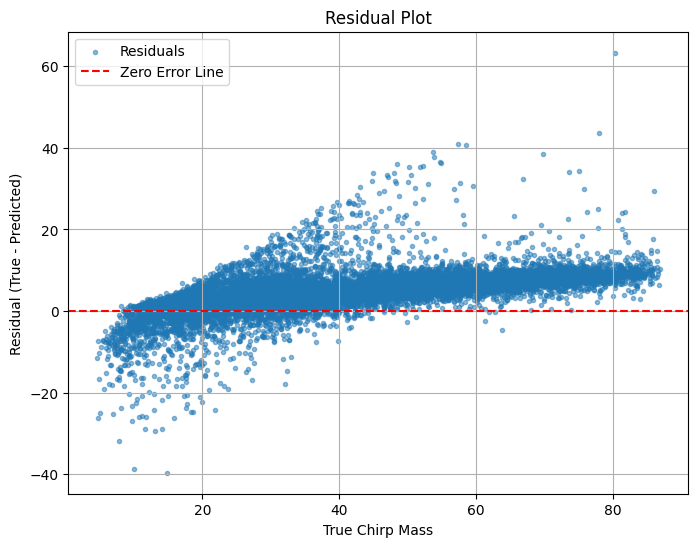

In [16]:
residuals = true_labels - predictions

plt.figure(figsize=(8, 6))
plt.scatter(true_labels, residuals, marker='.', alpha=0.5, label="Residuals")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Error Line")
plt.xlabel("True Chirp Mass")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual Plot")
plt.legend()
plt.grid(True)
plt.savefig('(3)_Media/Model_2_Performance_Residual.png')
plt.show()

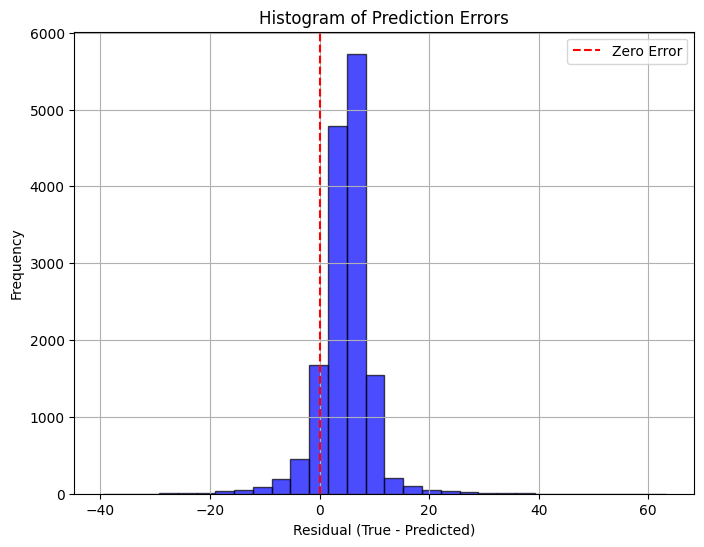

In [17]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', label="Zero Error")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors")
plt.legend()
plt.grid(True)
plt.savefig('(3)_Media/Model_2_Performance_Residual_Histogram.png')
plt.show()